# Проект промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали с `MAE` не более 6.8.

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

## Описание данных

Данные состоят из файлов, полученных из разных источников:
1. data_arc_new.csv — данные об электродах;
2. data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
3. data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
4. data_gas_new.csv — данные о продувке сплава газом;
5. data_temp_new.csv — результаты измерения температуры;
6. data_wire_new.csv — данные о проволочных материалах (объём);
7. data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии.

В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## План работы

Загрузка библиотек, их настройка
Создание своих функций

Предобработка данных:
1. Обработка пропусков
2. Обработка выбросов
3. Агрегация таблиц по `key`
4. Объединение таблиц по `key`
5. Создание новых признаков
6. Исследовательский анализ объединенной таблицы (в частности - корреляционный анализ)

Создание модели:
1. Разбиение датасета на `features` и `train`
2. Масштабирование признаков
3. Подбор гиперпараметров и тренировка моделей
4. Выбор лучшей модели и ее тестирование
5. Исследование важности признаков

Создание отчета

## Imports

In [1]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#models
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error as mae

## Library options

In [2]:
pd.set_option('display.max_columns', None)

## Functions

In [3]:
def clean_keys(dfs, bad_keys):
    new_dfs = []
    for data in dfs:
        new_dfs.append(data.loc[~(data['key'].isin(bad_keys))])
    return new_dfs

## Loading databases

In [4]:
try:
    
    data_arc_new = pd.read_csv('datasets/data_arc_new.csv', parse_dates=[1,2])
    data_arc_new.name = 'data_arc_new'

    data_bulk_new = pd.read_csv('datasets/data_bulk_new.csv')
    data_bulk_new.name = 'data_bulk_new'

    data_bulk_time_new = pd.read_csv('datasets/data_bulk_time_new.csv', parse_dates=[x for x in range(1,16)])
    data_bulk_time_new.name = 'data_bulk_time_new'

    data_gas_new = pd.read_csv('datasets/data_gas_new.csv')
    data_gas_new.name = 'data_gas_new'

    data_temp_new = pd.read_csv('datasets/data_temp_new.csv', parse_dates=[1])
    data_temp_new.name = 'data_temp_new'

    data_wire_new = pd.read_csv('datasets/data_wire_new.csv', parse_dates=True)
    data_wire_new.name = 'data_wire_new'

    data_wire_time_new = pd.read_csv('datasets/data_wire_time_new.csv', parse_dates=[x for x in range(1,10)])
    data_wire_time_new.name = 'data_wire_time_new'
    
except:
    
    print('Введите путь к каталогу в формате "каталог/"')
    path = input()
    
    data_arc_new = pd.read_csv(f'{path}data_arc_new.csv', parse_dates=[1,2])
    data_arc_new.name = 'data_arc_new'

    data_bulk_new = pd.read_csv(f'{path}data_bulk_new.csv')
    data_bulk_new.name = 'data_bulk_new'

    data_bulk_time_new = pd.read_csv(f'{path}data_bulk_time_new.csv', parse_dates=[x for x in range(1,16)])
    data_bulk_time_new.name = 'data_bulk_time_new'

    data_gas_new = pd.read_csv(f'{path}data_gas_new.csv')
    data_gas_new.name = 'data_gas_new'

    data_temp_new = pd.read_csv(f'{path}data_temp_new.csv', parse_dates=[1])
    data_temp_new.name = 'data_temp_new'

    data_wire_new = pd.read_csv(f'{path}data_wire_new.csv', parse_dates=True)
    data_wire_new.name = 'data_wire_new'

    data_wire_time_new = pd.read_csv(f'{path}data_wire_time_new.csv', parse_dates=[x for x in range(1,10)])
    data_wire_time_new.name = 'data_wire_time_new'

## Constants

In [5]:
DFS = [data_arc_new, 
           data_bulk_new, 
           data_bulk_time_new, 
           data_gas_new, data_temp_new, 
           data_wire_new, 
           data_wire_time_new]

TEST_SIZE = .25
RANDOM_STATE = 30723
N_JOBS = -1
CV = 3

## Exploratory data analysis

In [6]:
for df in DFS:
    
    print(df.name)
    print(df.info())
    print()

data_arc_new
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB
None

data_bulk_new
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk

### Пропуски

В столбце `key` пропусков нет нигде

`data_arc_new` - пропусков нет

`data_bulk_new` - пропуски во всех столбцах, во многих почти нет данных

`data_bulk_time_new` - пропуски во всех столбцах, во многих почти нет данных

`data_gas_new` - пропусков нет

`data_temp_new` - пропуске в столбце `Температура`

`data_wire_new` - пропуски во всех столбцах, во многих почти нет данных

`data_wire_time_new` - пропуски во всех столбцах, во многих почти нет данных

In [7]:
for df in DFS:
    
    print(df.name)
    display(df.head())
    print()

data_arc_new


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691



data_bulk_new


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



data_bulk_time_new


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47



data_gas_new


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



data_temp_new


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0



data_wire_new


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN



data_wire_time_new


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


### Тип данных

Тип данных во всех ячейках соответствует ожидаемому

### Описательная статистика

In [8]:
for df in DFS:
    print(df.name)
    display(df.describe())
    print()

data_arc_new


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284



data_bulk_new


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000



data_bulk_time_new


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000



data_gas_new


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040



data_temp_new


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000



data_wire_new


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604



data_wire_time_new


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Столбцов с минимальным значением равным нулю нет. Остальное лучше визуализировать.

### Распределение данных

  0%|          | 0/7 [00:00<?, ?it/s]

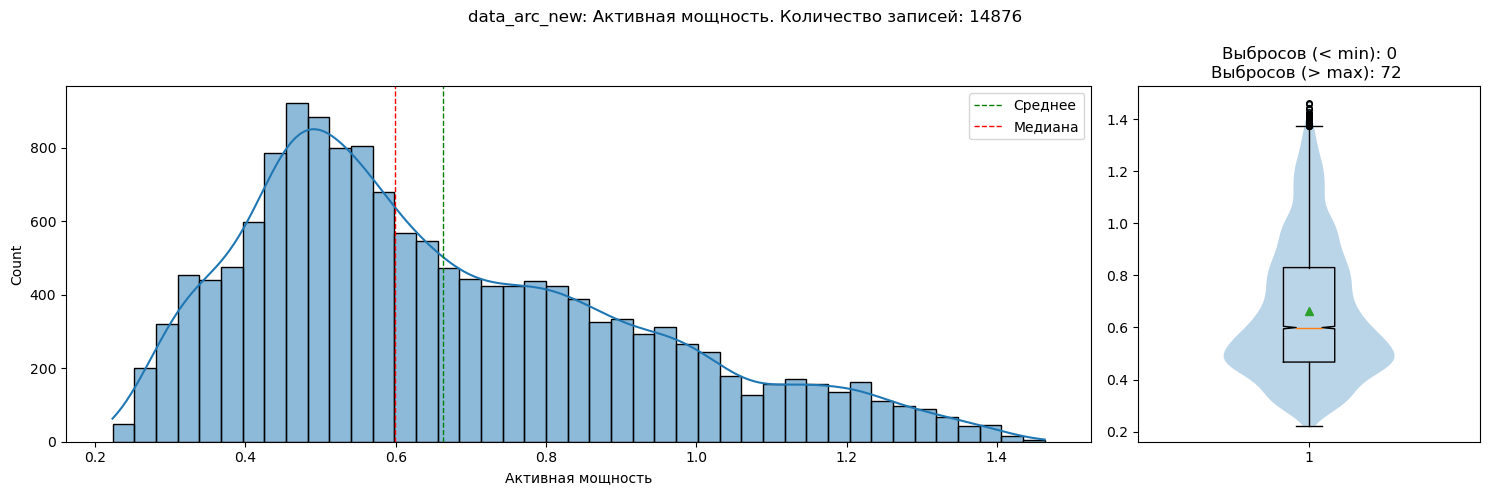

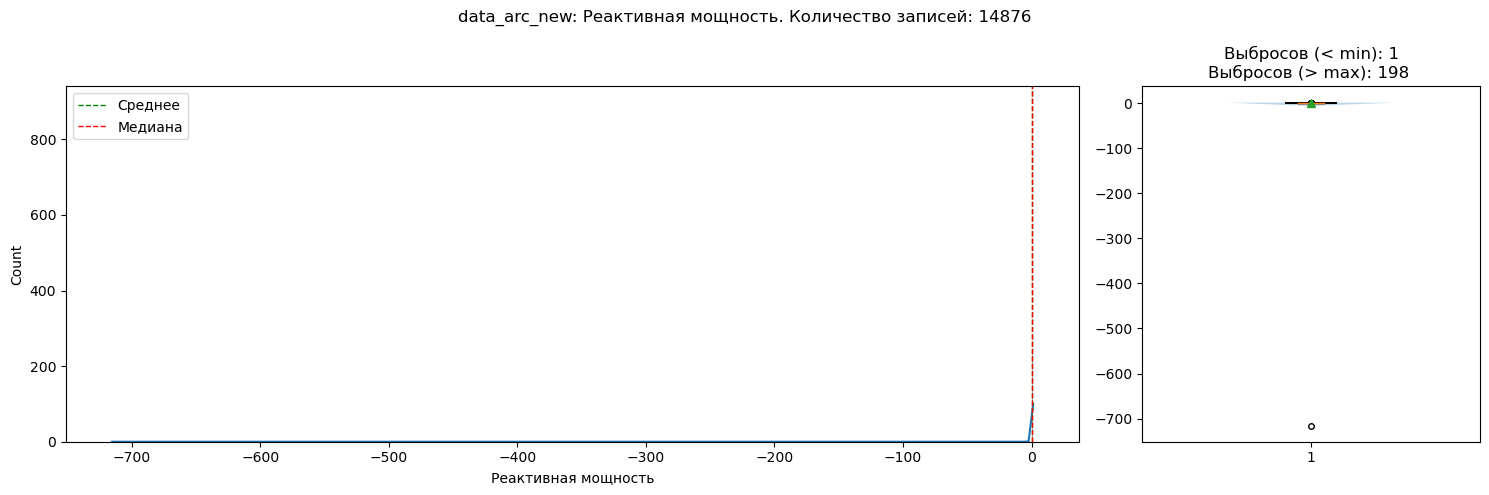

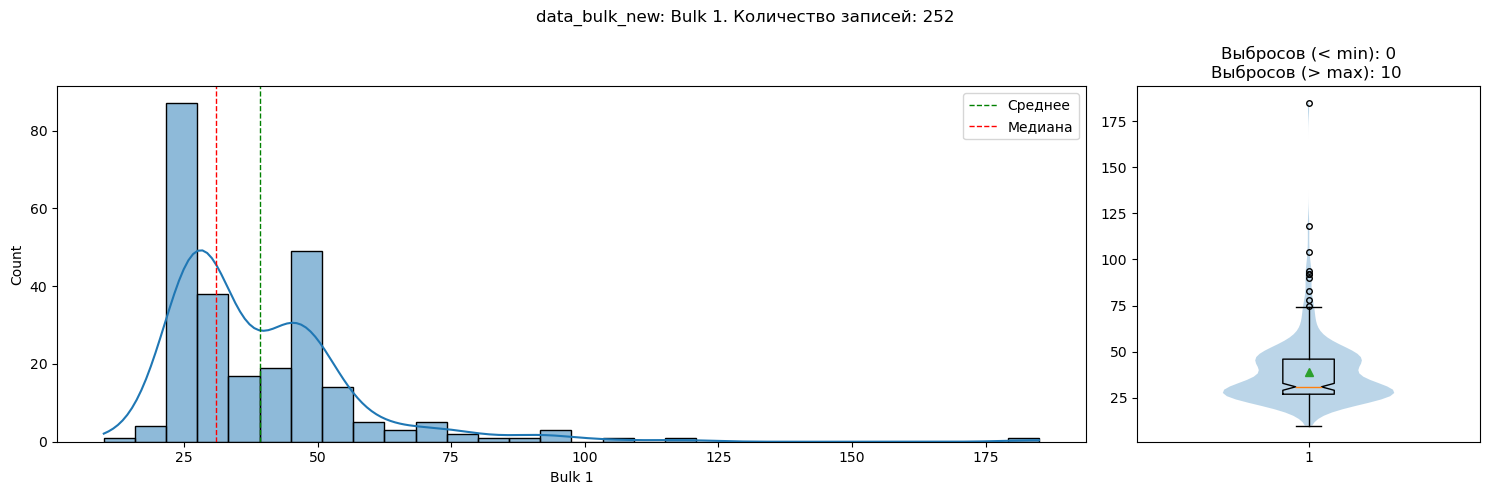

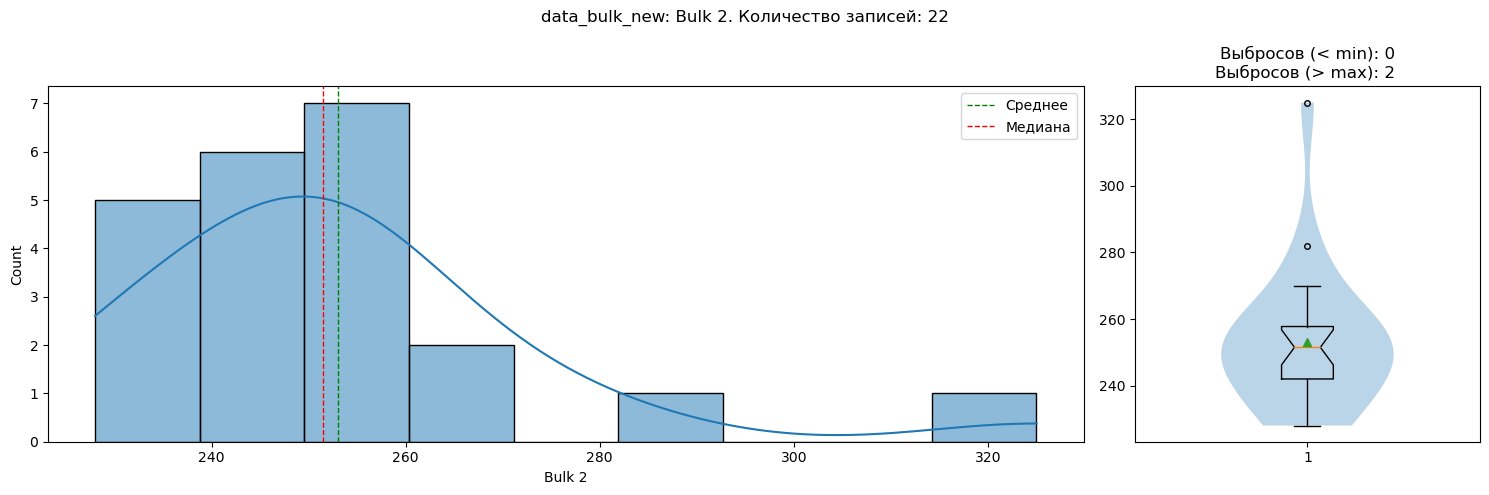

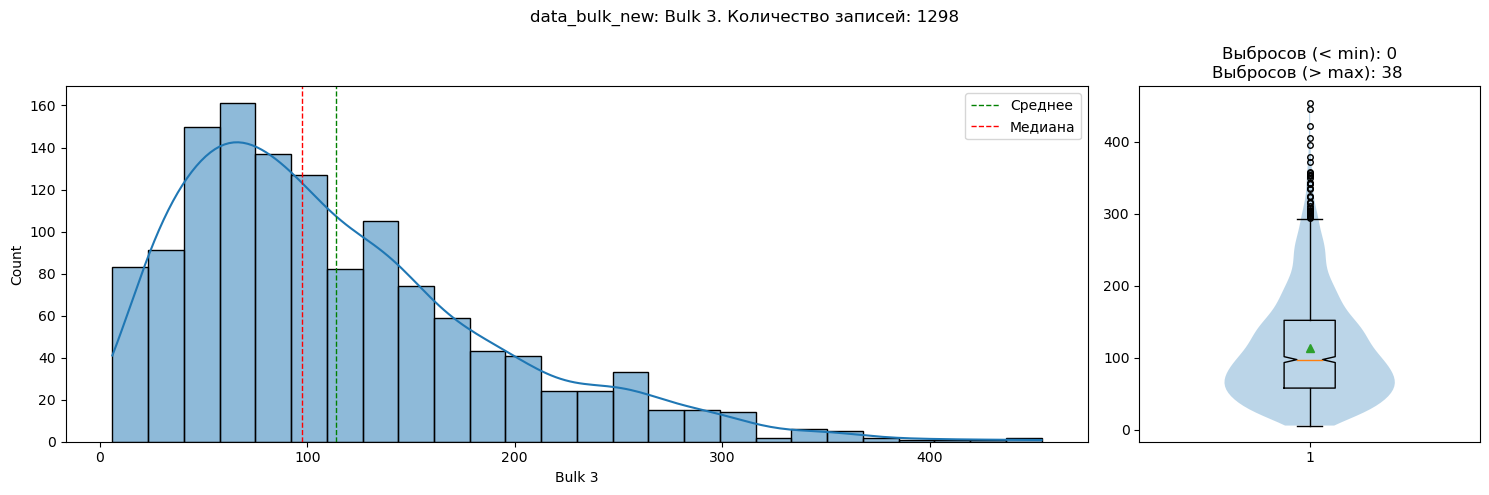

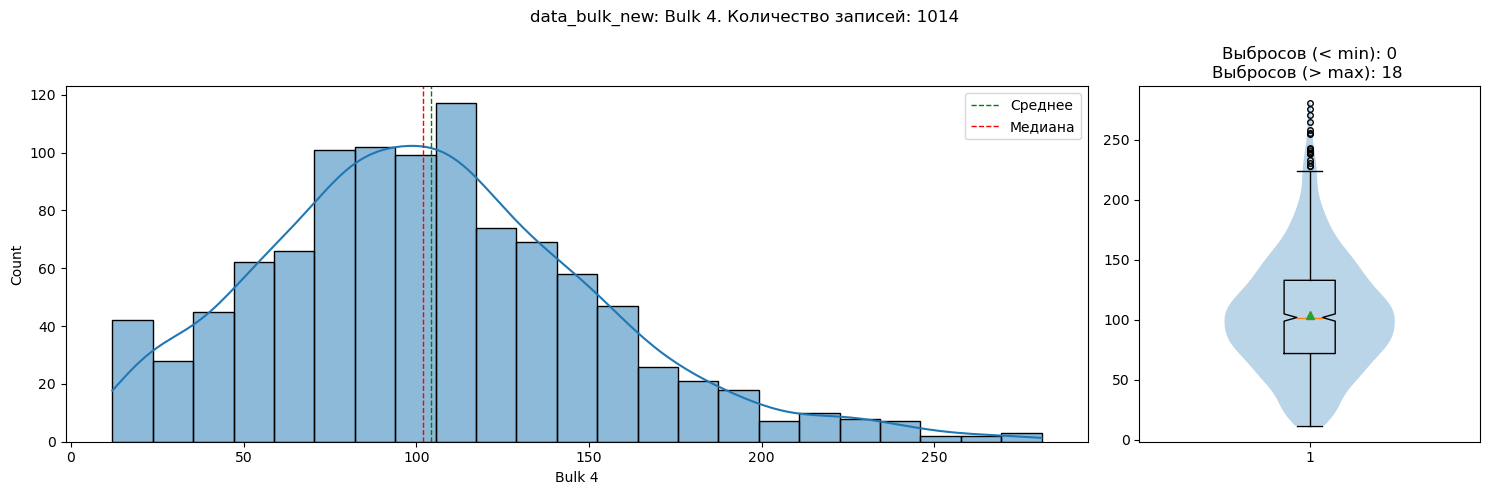

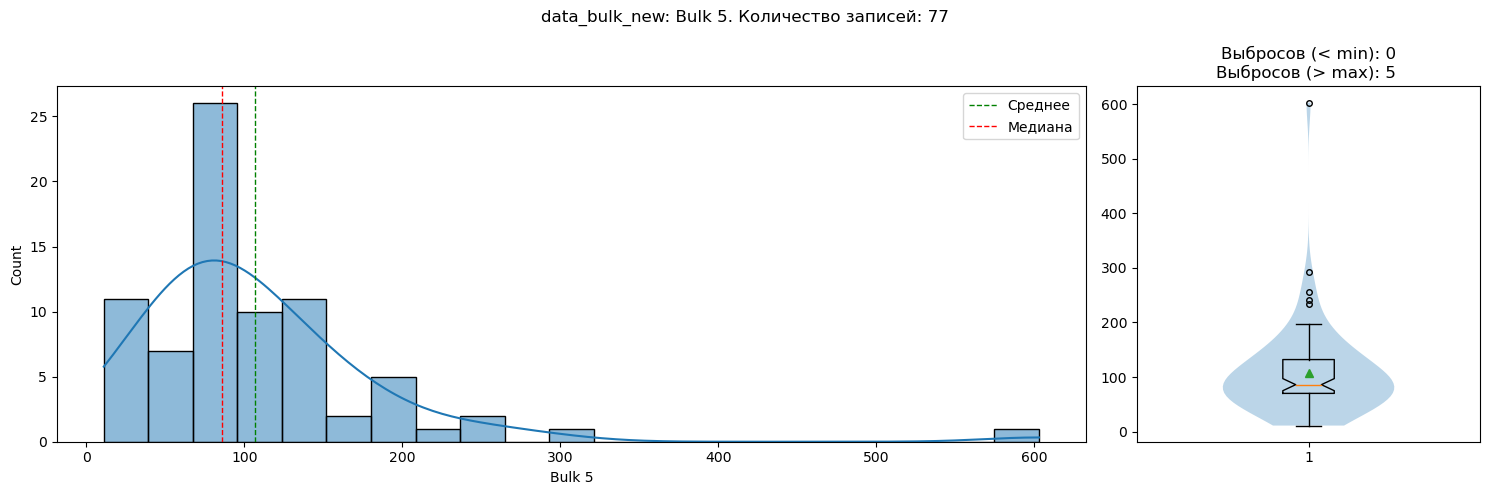

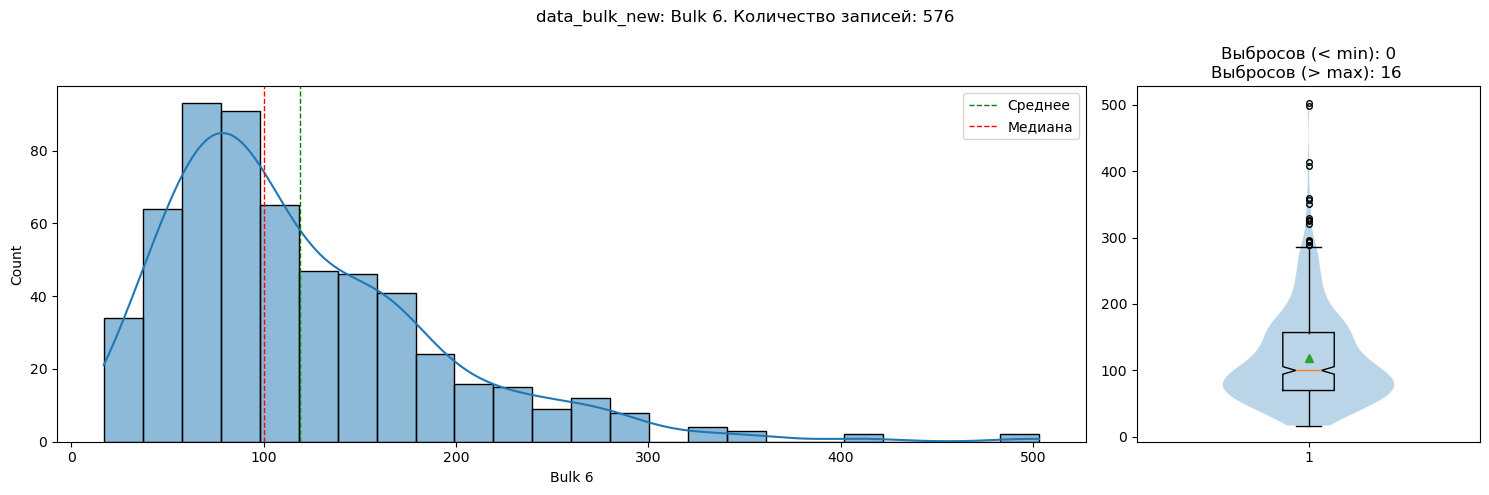

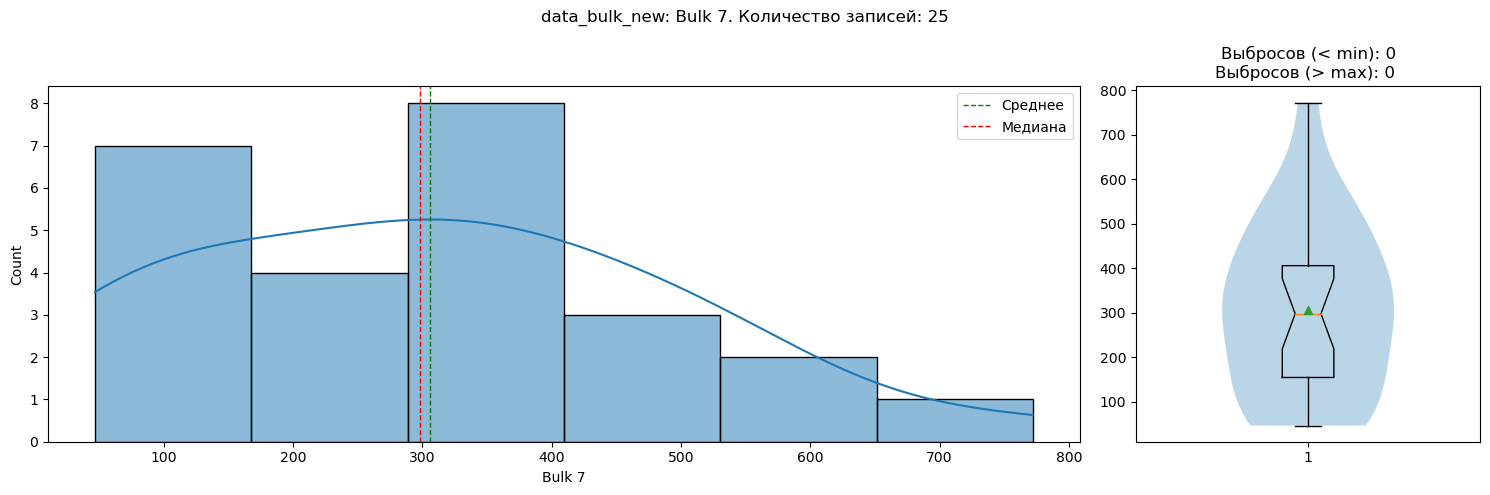

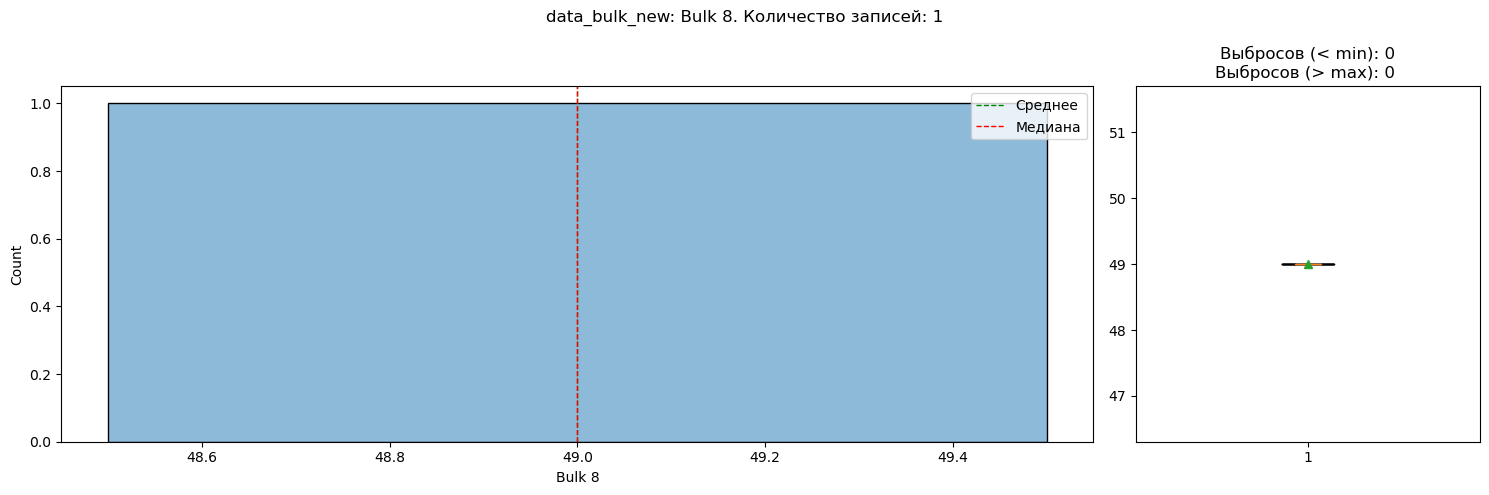

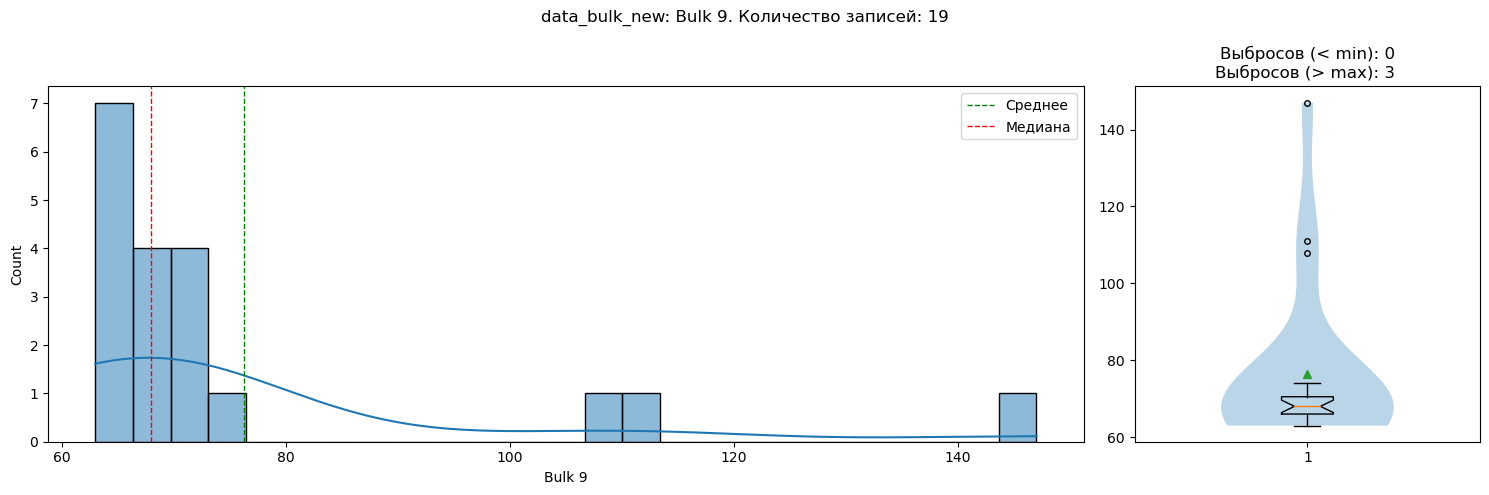

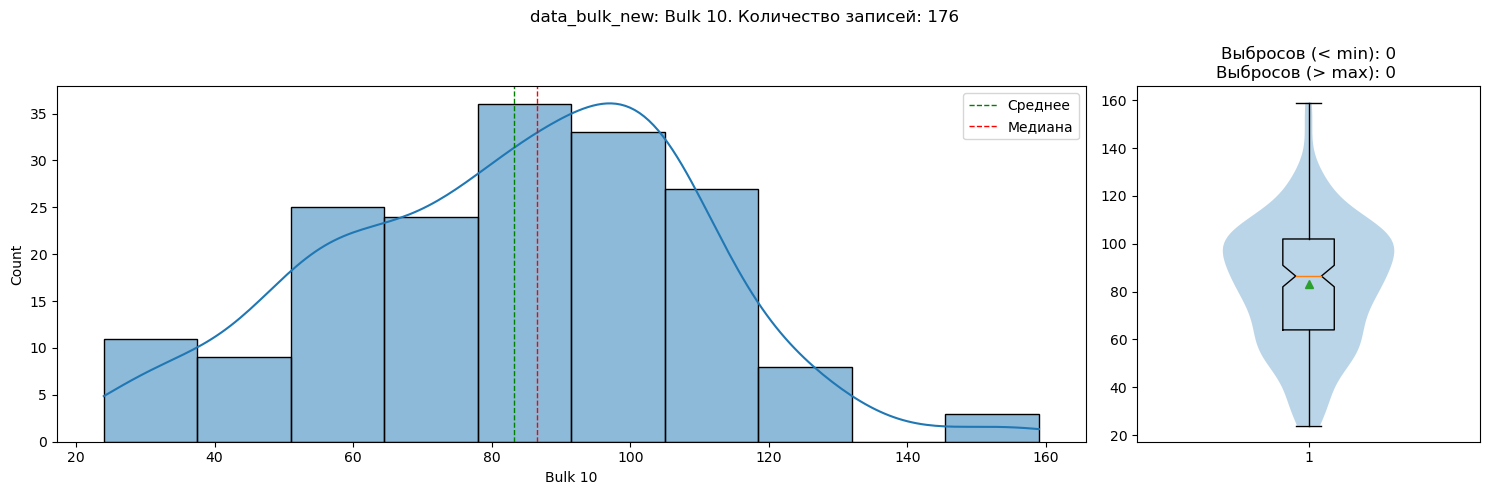

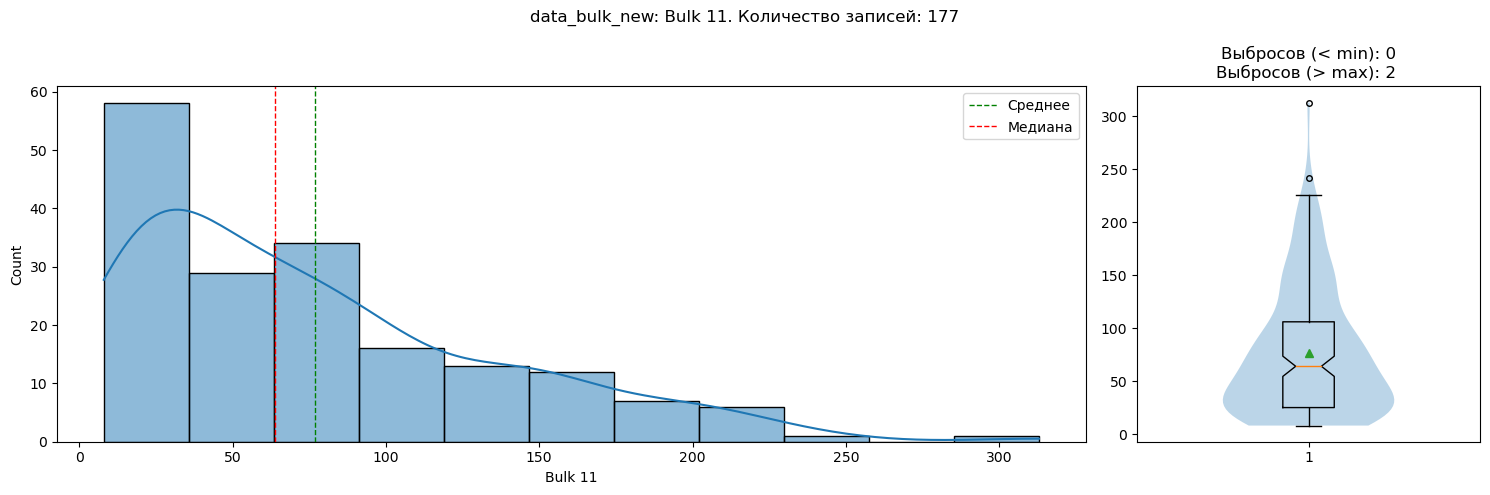

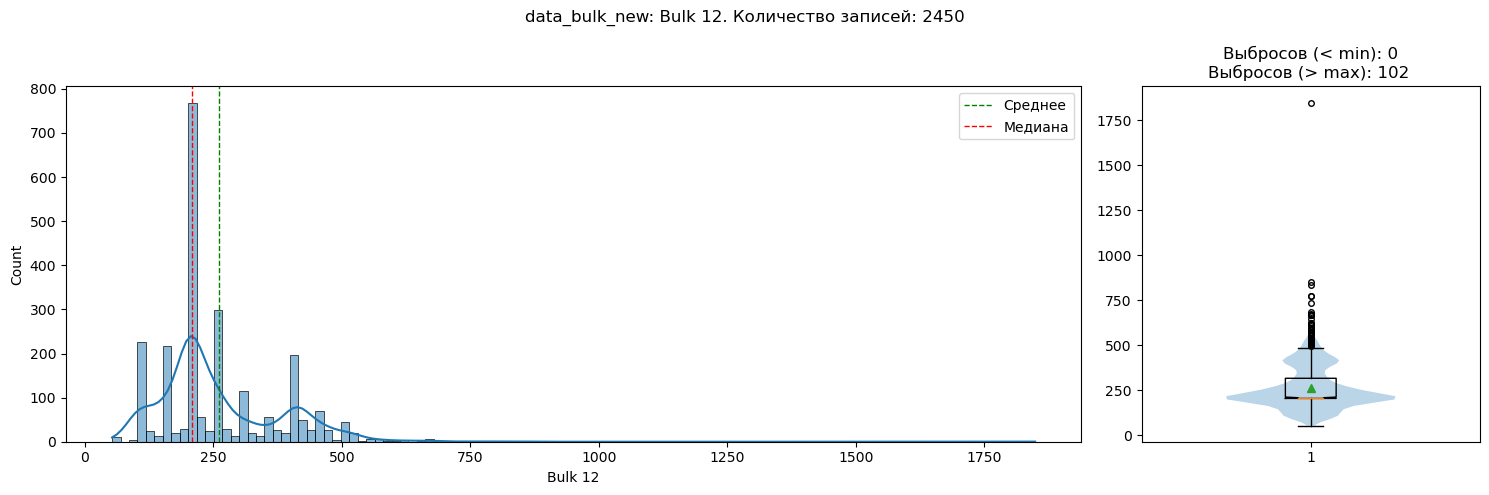

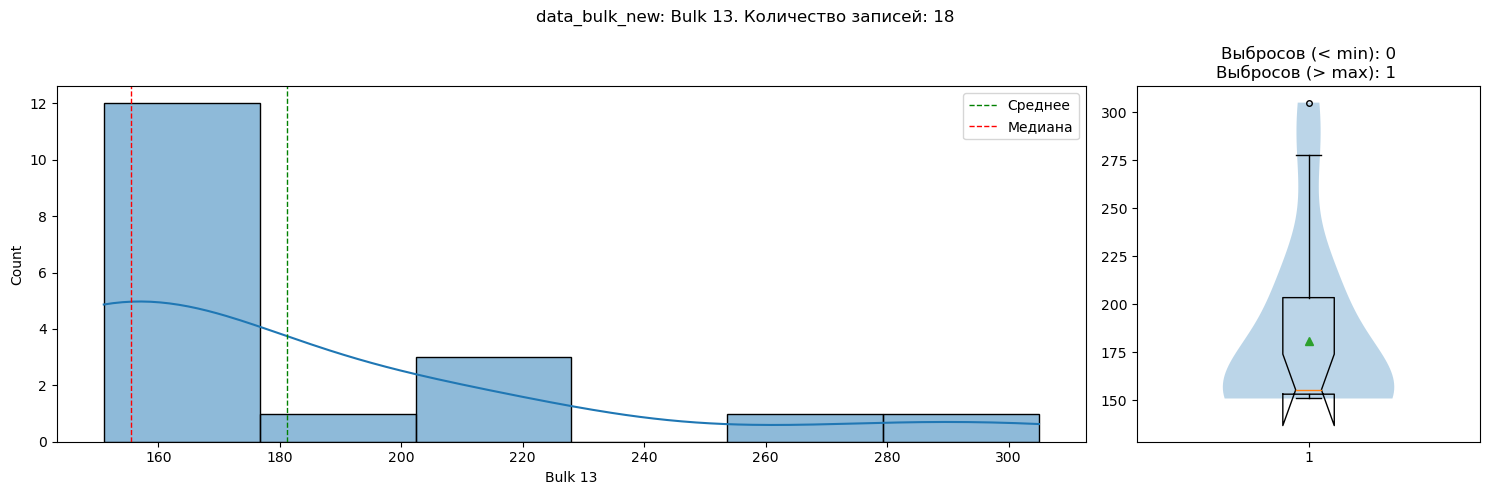

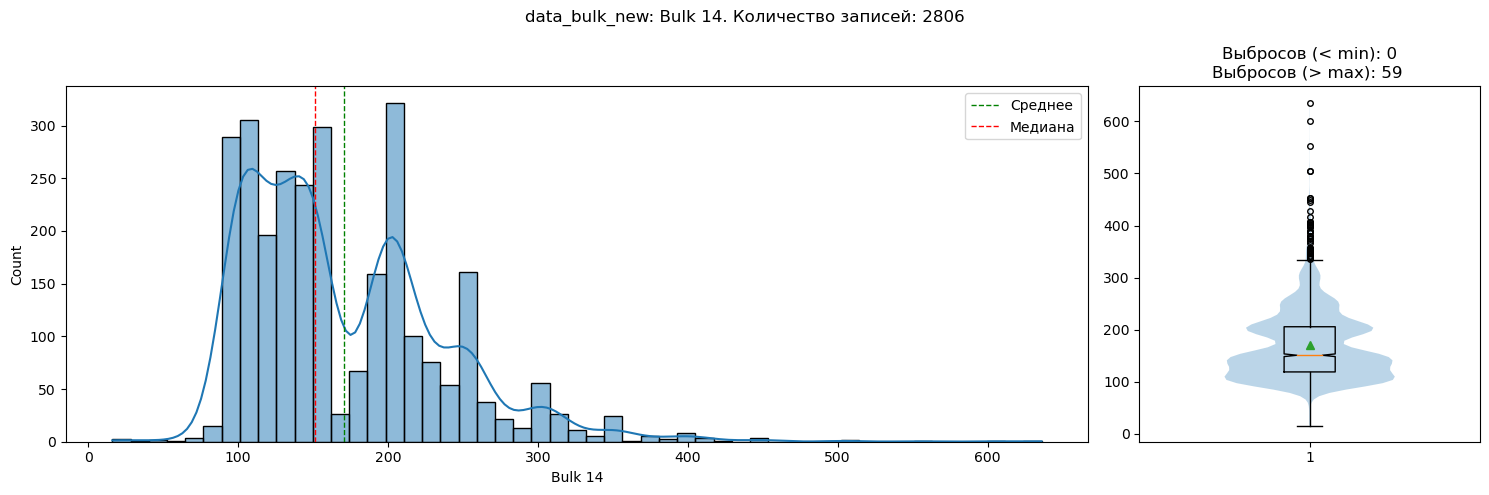

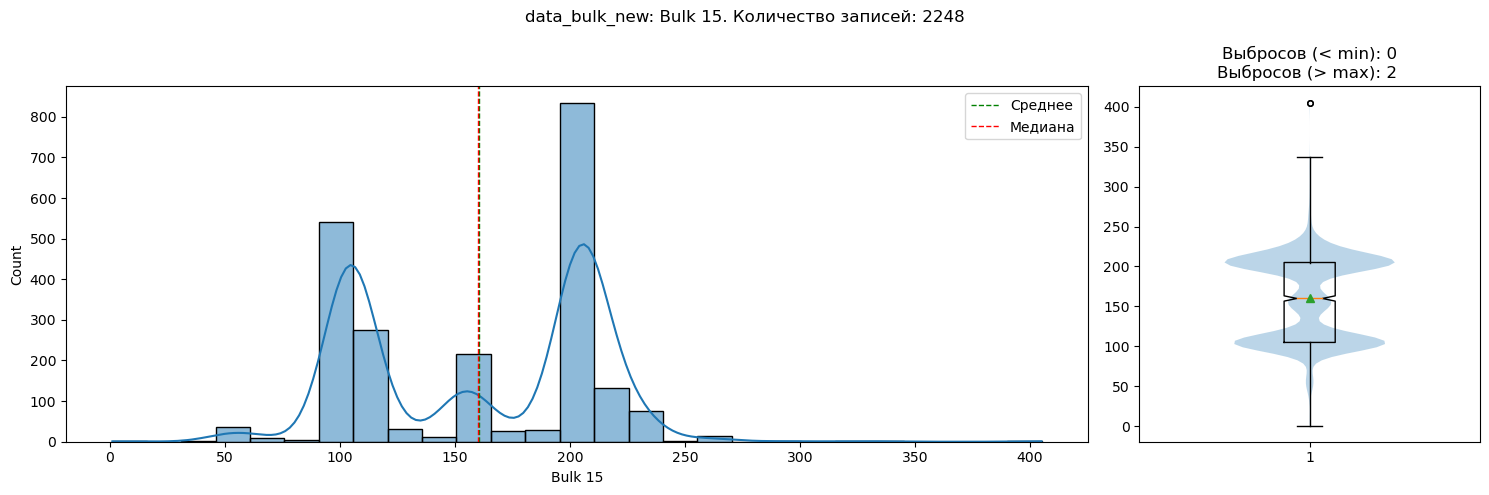

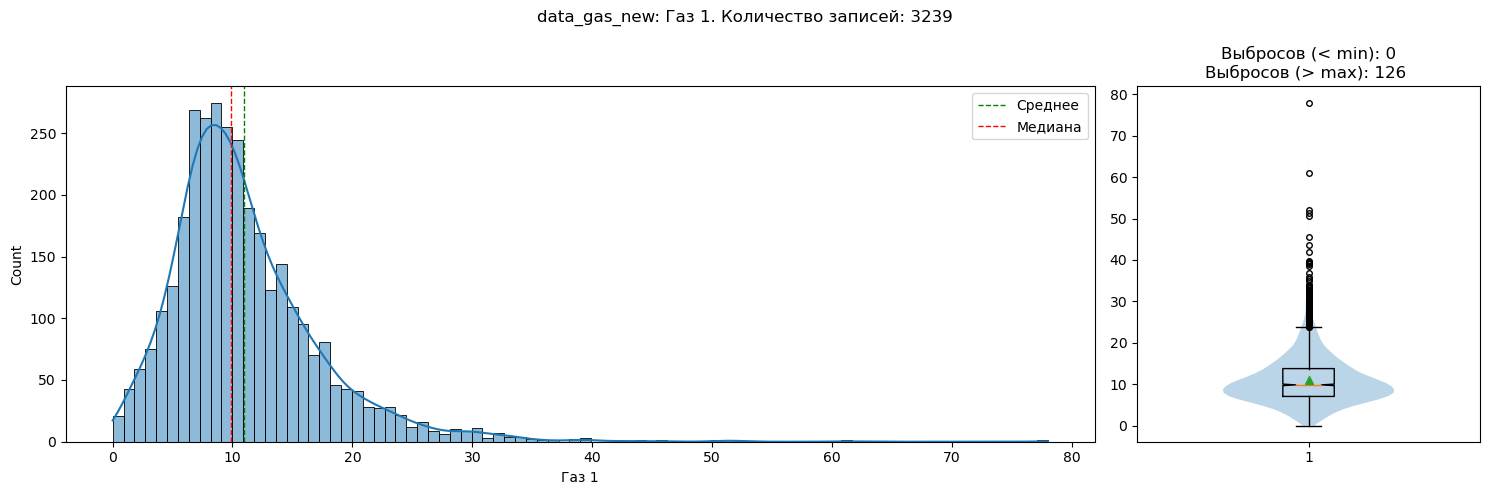

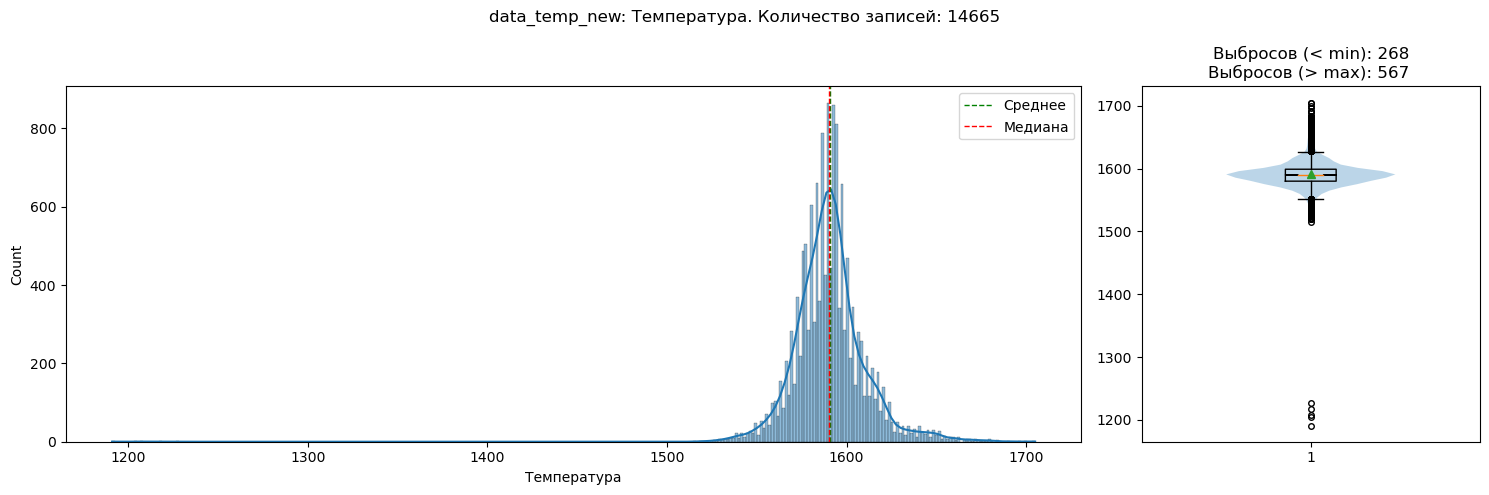

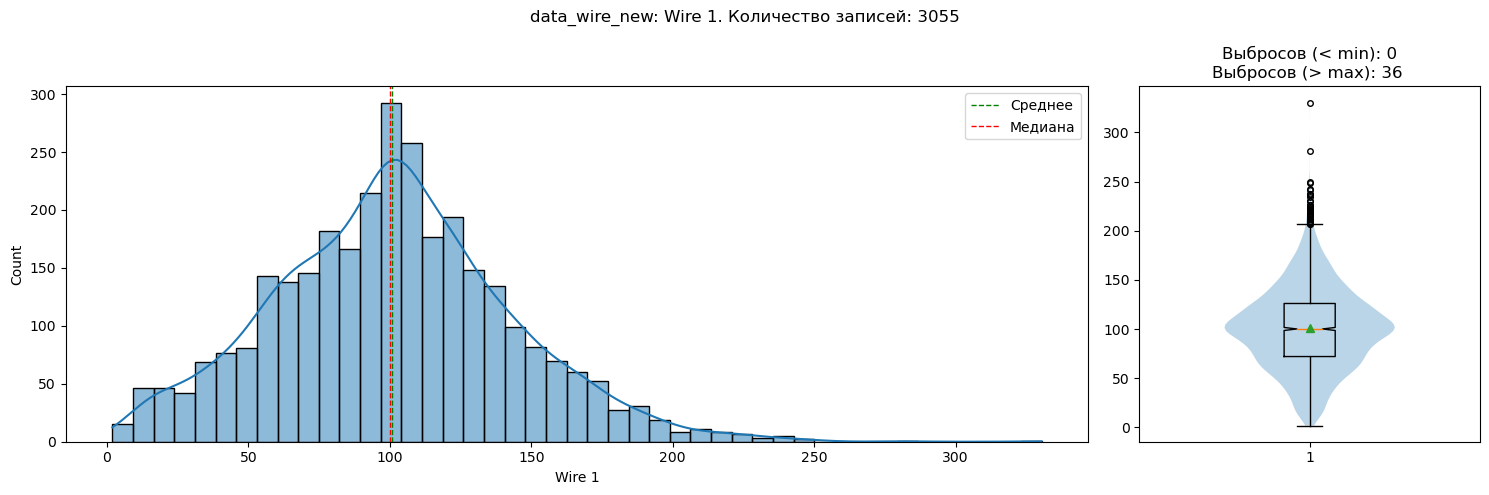

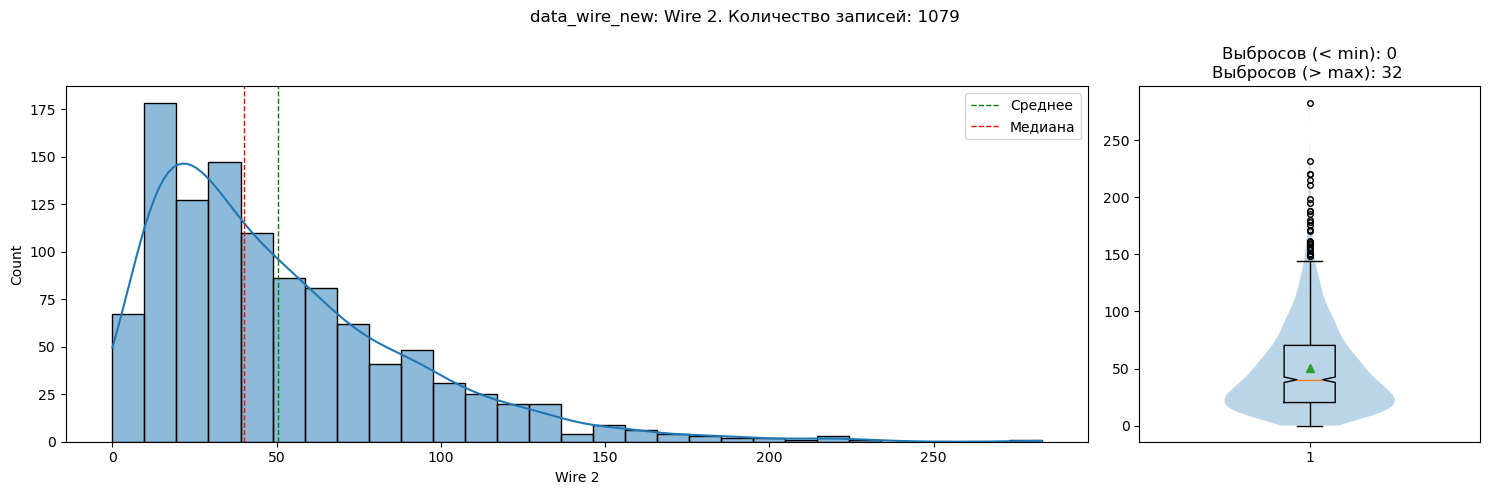

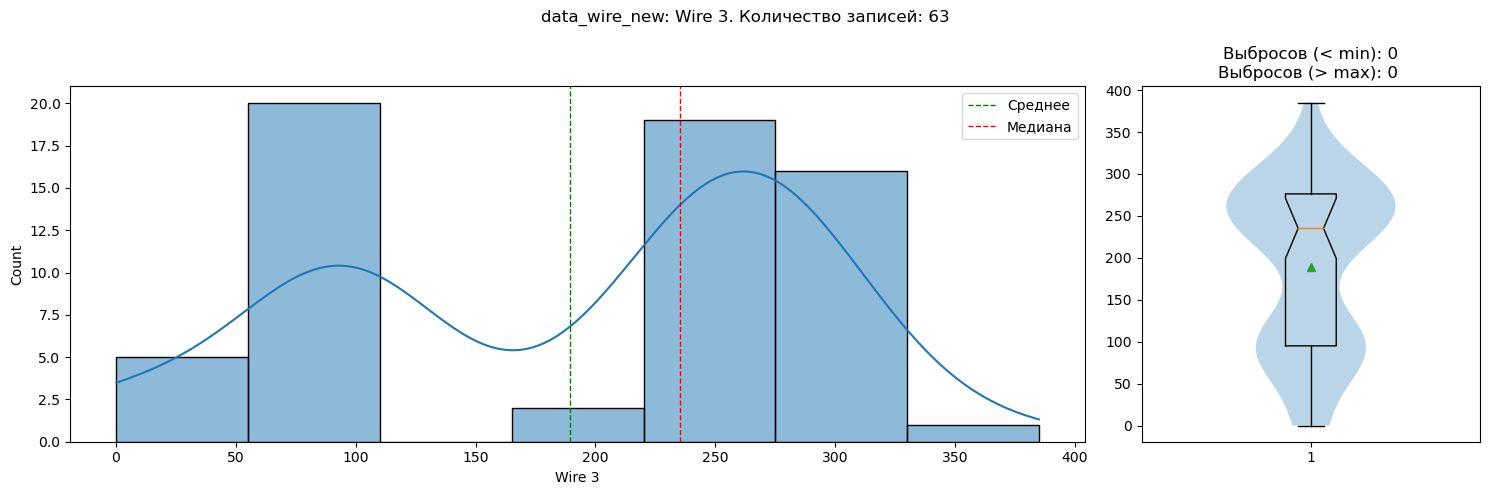

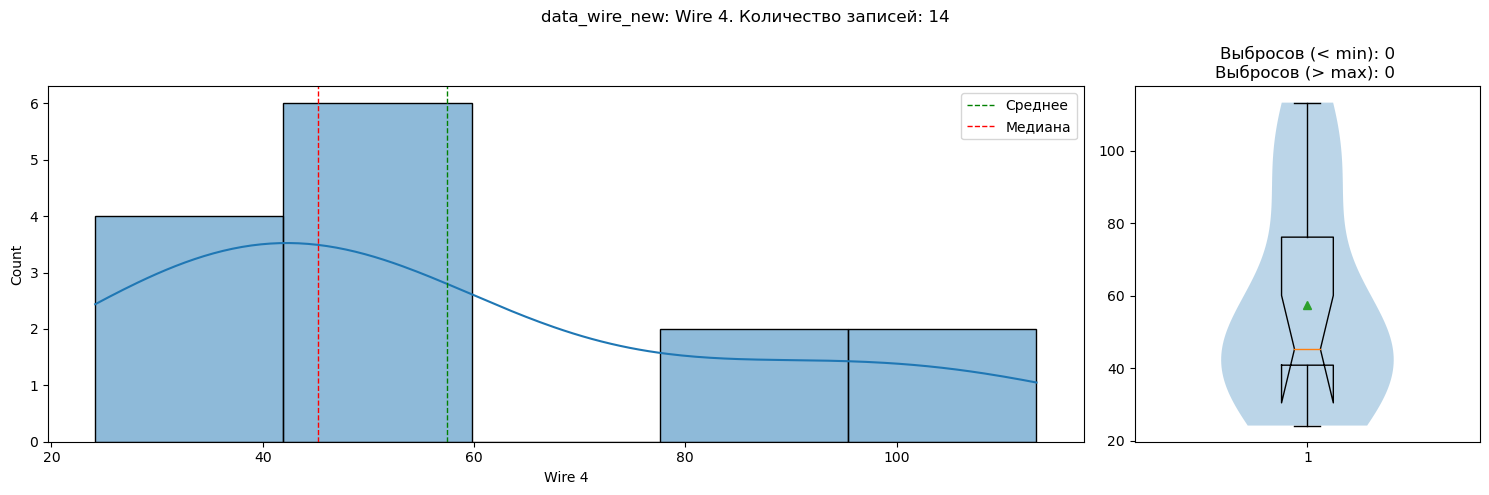

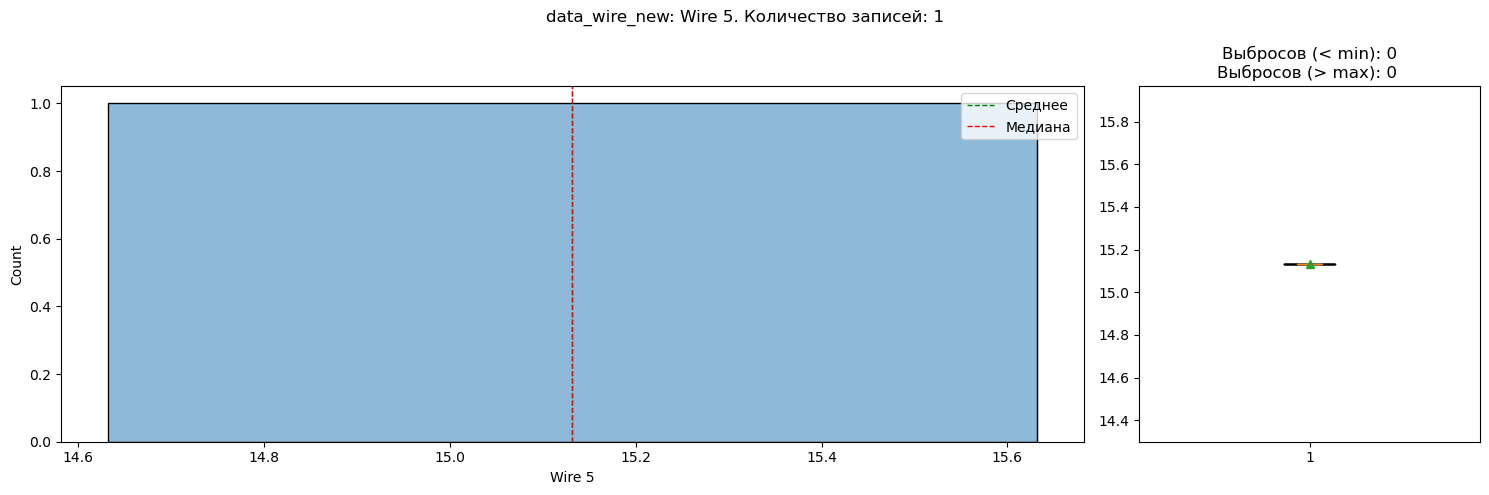

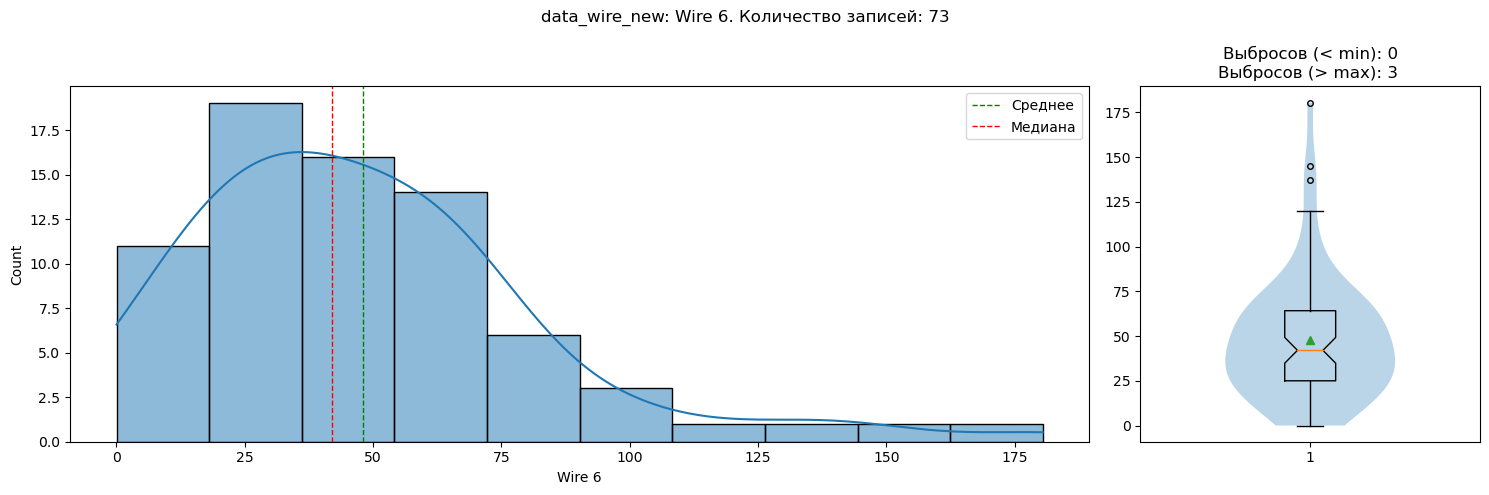

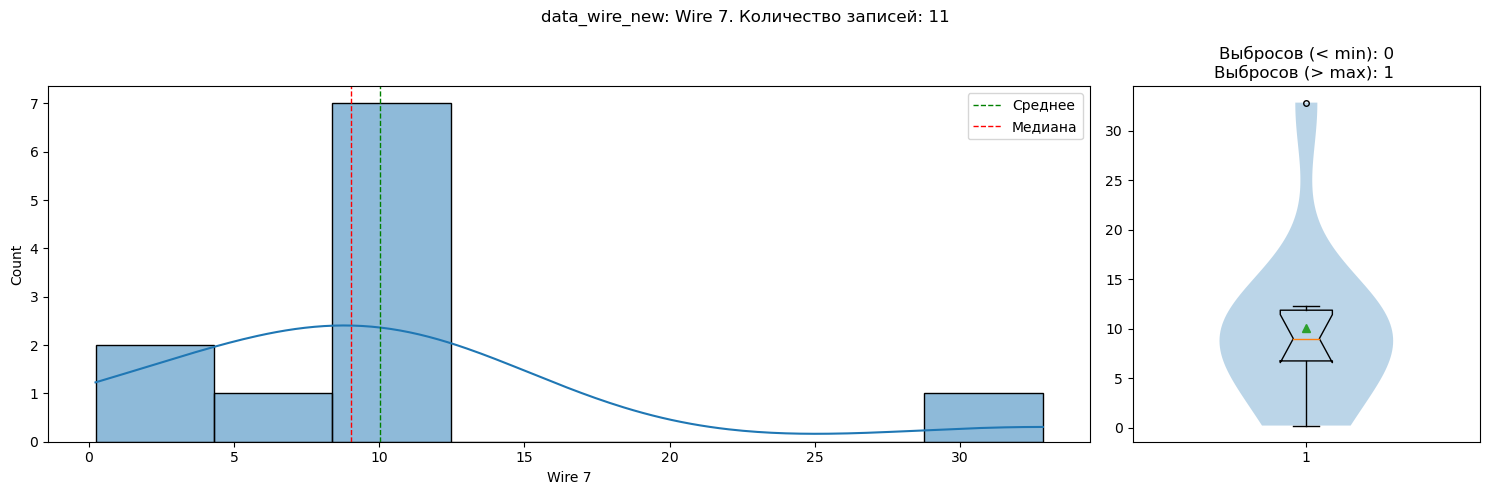

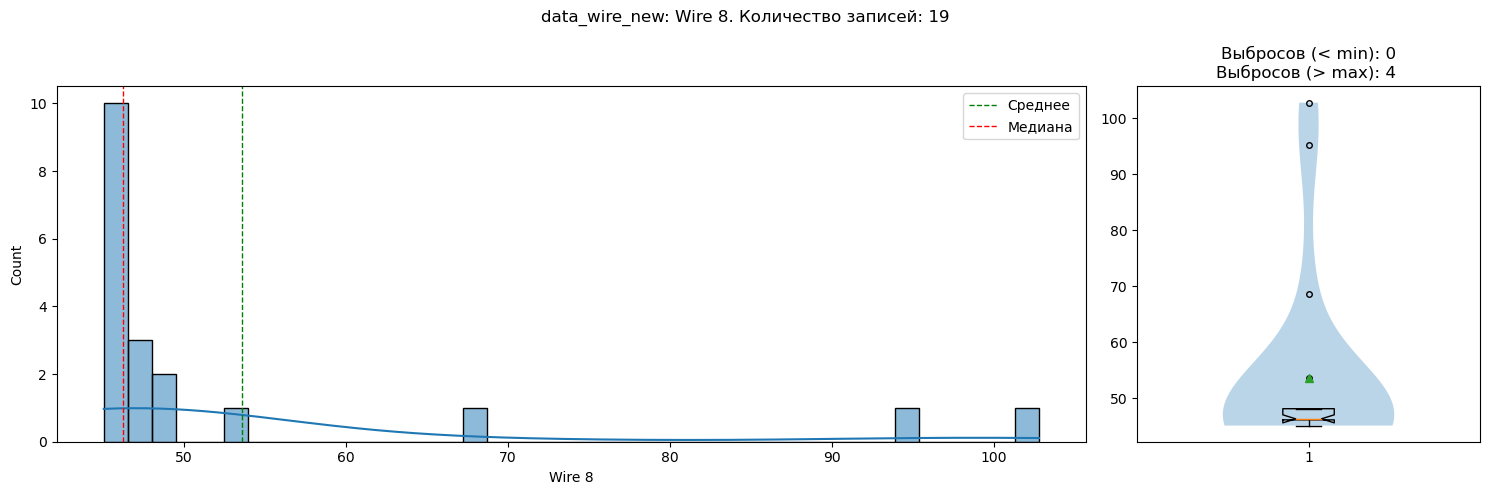

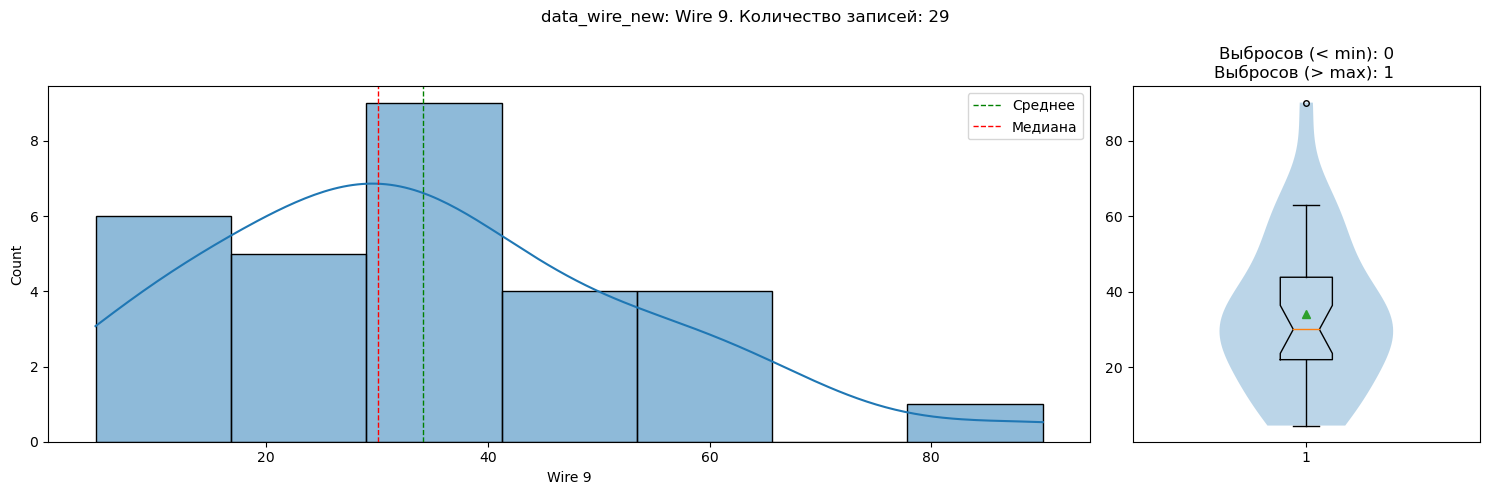

In [9]:
flierprops = dict(markersize=4)
for df in tqdm(DFS):
    
    for column in df.columns:
        if df[column].dtype == type(1.0):
            len_not_na = df[column].notna().sum()
            
            if len_not_na > 0:
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), gridspec_kw={'width_ratios': [3, 1]})
                fig.suptitle(f'{df.name}: {column}. Количество записей: {len_not_na}')
                sns.histplot(data=df, ax=ax1, x=column, kde=True)
                ax1.axvline(df[column].mean(), color = 'green', linewidth=1, linestyle='dashed', label='Среднее')
                ax1.axvline(df[column].median(), color = 'red', linewidth=1, linestyle='dashed', label='Медиана')
                ax1.legend()
                
                bp = ax2.boxplot(df[column].dropna(), notch=True, showmeans=True, flierprops=flierprops)
                caps_min = [item.get_ydata() for item in bp['caps']][0][0]
                caps_max = [item.get_ydata() for item in bp['caps']][1][0]
                min_fliers = sum(df[column] < caps_min)
                max_fliers = sum(df[column] > caps_max)
            
                ax2.violinplot(df[column].dropna(), showextrema=False)
                
                ax2.set_title(f'Выбросов (< min): {min_fliers}\nВыбросов (> max): {max_fliers} ')
                plt.tight_layout()
                plt.show()

Столбцов с нормально распределенными данными нет.

В `data_arc_new['Реактивная мощность']` есть отрицательное значение -715.48, что не возможно. Взять модуль тоже не вариант - максимальное значение в данном стобце 1.27. Остается только удалить. 

Также бросаются в глаза выбросы ниже 1300 в `data_temp_new['Температура']`



### Дубликаты

In [10]:
print('Количество дубликатов')
print()
for df in DFS:
    print(df.name)
    print(f'Количество записей {len(df)}')
    print(df.duplicated().sum())
    print()

Количество дубликатов

data_arc_new
Количество записей 14876
0

data_bulk_new
Количество записей 3129
0

data_bulk_time_new
Количество записей 3129
0

data_gas_new
Количество записей 3239
0

data_temp_new
Количество записей 18092
0

data_wire_new
Количество записей 3081
0

data_wire_time_new
Количество записей 3081
0



In [11]:
print('Количество дубликатов key')
print()
for df in DFS:
    print(df.name)
    print(f'Количество записей {len(df)}')
    print('Количество дубликатов', df['key'].duplicated().sum())

    print()

Количество дубликатов key

data_arc_new
Количество записей 14876
Количество дубликатов 11662

data_bulk_new
Количество записей 3129
Количество дубликатов 0

data_bulk_time_new
Количество записей 3129
Количество дубликатов 0

data_gas_new
Количество записей 3239
Количество дубликатов 0

data_temp_new
Количество записей 18092
Количество дубликатов 14876

data_wire_new
Количество записей 3081
Количество дубликатов 0

data_wire_time_new
Количество записей 3081
Количество дубликатов 0



In [12]:
print('Количество key')
print()
for df in DFS:
    print(df.name)
    len_uniq = len(df['key'].unique())
    print(f'Количество записей {len(df)}')
    print(f'Количество уникальных key {len_uniq}')
    print()
    

Количество key

data_arc_new
Количество записей 14876
Количество уникальных key 3214

data_bulk_new
Количество записей 3129
Количество уникальных key 3129

data_bulk_time_new
Количество записей 3129
Количество уникальных key 3129

data_gas_new
Количество записей 3239
Количество уникальных key 3239

data_temp_new
Количество записей 18092
Количество уникальных key 3216

data_wire_new
Количество записей 3081
Количество уникальных key 3081

data_wire_time_new
Количество записей 3081
Количество уникальных key 3081



Данные о некоторых партиях есть не во всех таблицах

### Выводы по исследовательскому анализу данных

Пропуски:

1. `В столбце key` пропусков нет нигде

2. `data_arc_new` - пропусков нет

3. `data_bulk_new` - пропуски во всех столбцах, во многих почти нет данных

4. `data_bulk_time_new` - пропуски во всех столбцах, во многих почти нет данных

5. `ata_gas_new` - пропусков нет

6. `data_temp_new` - пропуске в столбце `Температура`

7. `data_wire_new` - пропуски во всех столбцах, во многих почти нет данных

8. `data_wire_time_new` - пропуски во всех столбцах, во многих почти нет данных

Тип данных во всех ячейках соответствует ожидаемому

Столбцов с нормально распределенными данными нет.

В `data_arc_new['Реактивная мощность']` есть отрицательное значение -715.48, что не возможно. Взять модуль тоже не вариан - максимальное значение в данном стобце 1.27. Остается только удалить. Также бросаются в глаза выбросы ниже 1300 в `data_temp_new['Температура']`

Полных дубликатов нет

Есть дубликаты по `key` что связано с разными циклами обработки партии

Данные о некоторых партиях есть не во всех таблицах

## Предобработка данных

### Удаление выбросов

In [13]:
bad_keys = list(data_arc_new.loc[data_arc_new['Реактивная мощность'] < 0, 'key'].values)
bad_keys.extend(list(data_temp_new.loc[data_temp_new['Температура'] < 1400, 'key'].values))

In [14]:
bad_keys

[2116, 867, 1214, 1619, 2052, 2561]

In [15]:
DFS = clean_keys(DFS, bad_keys)

In [16]:
(
    data_arc_new, 
    data_bulk_new, 
    data_bulk_time_new, 
    data_gas_new, 
    data_temp_new, 
    data_wire_new, 
    data_wire_time_new
) = DFS

{'whiskers': [<matplotlib.lines.Line2D at 0x1cbcce01c40>,
 'caps': [<matplotlib.lines.Line2D at 0x1cbcce11220>,
 'boxes': [<matplotlib.lines.Line2D at 0x1cbcce01970>],
 'medians': [<matplotlib.lines.Line2D at 0x1cbcce117c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1cbcce11a90>],
 'means': []}

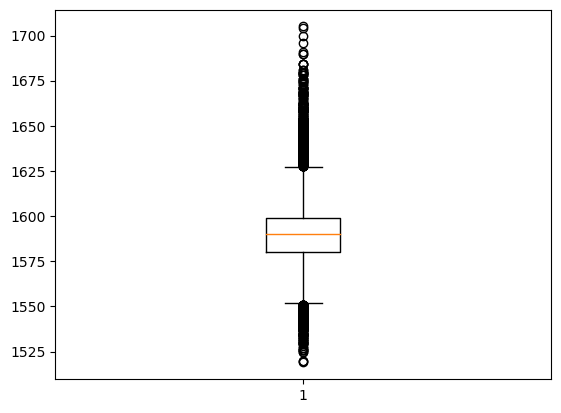

In [17]:
plt.boxplot(data_temp_new['Температура'].dropna())

### Агрегация

In [18]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14850 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14850 non-null  int64         
 1   Начало нагрева дугой  14850 non-null  datetime64[ns]
 2   Конец нагрева дугой   14850 non-null  datetime64[ns]
 3   Активная мощность     14850 non-null  float64       
 4   Реактивная мощность   14850 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 696.1 KB


#### Создание нового признаков `Время нагрева` и `Мощность`

In [19]:
data_arc_new['Время нагрева'] = (data_arc_new['Конец нагрева дугой'] - data_arc_new['Начало нагрева дугой']) / pd.tseries.offsets.Second(1)

C:\Users\yaros\AppData\Local\Temp\ipykernel_17744\3556845985.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_arc_new['Время нагрева'] = (data_arc_new['Конец нагрева дугой'] - data_arc_new['Начало нагрева дугой']) / pd.tseries.offsets.Second(1)


In [20]:
data_arc = data_arc_new.pivot_table(
    index = 'key', 
    values = [
        'Начало нагрева дугой', 
        'Конец нагрева дугой', 
        'Активная мощность', 
        'Реактивная мощность', 
        'Время нагрева'
    ], 
    aggfunc = {
        'Начало нагрева дугой': min,
        'Конец нагрева дугой': max,
        'Время нагрева': sum,
        'Активная мощность': sum,
        'Реактивная мощность': sum
    }
)

In [21]:
data_arc['Мощность'] = data_arc['Активная мощность'] * data_arc['Реактивная мощность']
data_arc.drop(['Активная мощность', 'Реактивная мощность'], axis=1, inplace=True)

In [22]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18060 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18060 non-null  int64         
 1   Время замера  18060 non-null  datetime64[ns]
 2   Температура   14638 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 564.4 KB


In [23]:
data_temp_first = data_temp_new.sort_values(['key', 'Время замера']).groupby('key').nth(0)
data_temp_first.columns = ['Время первого замера', 'Начальная температура']
data_temp_first.head()

,Время первого замера,Начальная температура
key,,
1,2019-05-03 11:02:04,1571.0
2,2019-05-03 11:34:04,1581.0
3,2019-05-03 12:06:44,1596.0
4,2019-05-03 12:39:27,1601.0
5,2019-05-03 13:11:03,1576.0


In [24]:
data_temp_last = data_temp_new.sort_values(['key', 'Время замера']).groupby('key').nth(-1)
data_temp_last.columns = ['Время последнего замера', 'Конечная температура']
data_temp_last.head()

,Время последнего замера,Конечная температура
key,,
1,2019-05-03 11:30:38,1613.0
2,2019-05-03 11:55:09,1602.0
3,2019-05-03 12:35:57,1599.0
4,2019-05-03 12:59:47,1625.0
5,2019-05-03 13:36:39,1602.0


In [25]:
data_temp = data_temp_first.merge(data_temp_last, on='key')
data_temp.head()

,Время первого замера,Начальная температура,Время последнего замера,Конечная температура
key,,,,
1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0
2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0
3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0
4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0
5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0


In [26]:
data_temp

,Время первого замера,Начальная температура,Время последнего замера,Конечная температура
key,,,,
1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0
2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0
3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0
4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0
5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0
...,...,...,...,...
3237,2019-09-06 11:31:15,1569.0,2019-09-06 11:55:45,NaN
3238,2019-09-06 12:16:15,1584.0,2019-09-06 12:34:37,NaN
3239,2019-09-06 14:16:50,1598.0,2019-09-06 15:09:55,NaN


### Merge

In [27]:
dataset = data_bulk_new.merge(data_bulk_time_new, on='key')
dataset = dataset.merge(data_arc, on='key')
dataset = dataset.merge(data_gas_new, on='key')
dataset = dataset.merge(data_wire_new, on='key')
dataset = dataset.merge(data_wire_time_new, on='key')
dataset = dataset.merge(data_temp, on='key')

In [28]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3016 entries, 0 to 3015
Data columns (total 58 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   key                      3016 non-null   int64         
 1   Bulk 1_x                 252 non-null    float64       
 2   Bulk 2_x                 22 non-null     float64       
 3   Bulk 3_x                 1291 non-null   float64       
 4   Bulk 4_x                 1010 non-null   float64       
 5   Bulk 5_x                 77 non-null     float64       
 6   Bulk 6_x                 569 non-null    float64       
 7   Bulk 7_x                 24 non-null     float64       
 8   Bulk 8_x                 1 non-null      float64       
 9   Bulk 9_x                 19 non-null     float64       
 10  Bulk 10_x                176 non-null    float64       
 11  Bulk 11_x                177 non-null    float64       
 12  Bulk 12_x                2352 non-

In [29]:
dataset.head()

,key,Bulk 1_x,Bulk 2_x,Bulk 3_x,Bulk 4_x,Bulk 5_x,Bulk 6_x,Bulk 7_x,Bulk 8_x,Bulk 9_x,Bulk 10_x,Bulk 11_x,Bulk 12_x,Bulk 13_x,Bulk 14_x,Bulk 15_x,Bulk 1_y,Bulk 2_y,Bulk 3_y,Bulk 4_y,Bulk 5_y,Bulk 6_y,Bulk 7_y,Bulk 8_y,Bulk 9_y,Bulk 10_y,Bulk 11_y,Bulk 12_y,Bulk 13_y,Bulk 14_y,Bulk 15_y,Время нагрева,Конец нагрева дугой,Начало нагрева дугой,Мощность,Газ 1,Wire 1_x,Wire 2_x,Wire 3_x,Wire 4_x,Wire 5_x,Wire 6_x,Wire 7_x,Wire 8_x,Wire 9_x,Wire 1_y,Wire 2_y,Wire 3_y,Wire 4_y,Wire 5_y,Wire 6_y,Wire 7_y,Wire 8_y,Wire 9_y,Время первого замера,Начальная температура,Время последнего замера,Конечная температура
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43,1098.0,2019-05-03 11:28:37,2019-05-03 11:02:14,6.507169,29.749986,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39,811.0,2019-05-03 11:53:18,2019-05-03 11:34:14,3.109324,12.555561,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16,655.0,2019-05-03 12:32:19,2019-05-03 12:06:54,11.936771,28.554793,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36,741.0,2019-05-03 12:57:50,2019-05-03 12:39:37,5.567226,18.841219,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47,869.0,2019-05-03 13:33:55,2019-05-03 13:11:13,3.802959,5.413692,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0


In [30]:
dataset.describe()

,key,Bulk 1_x,Bulk 2_x,Bulk 3_x,Bulk 4_x,Bulk 5_x,Bulk 6_x,Bulk 7_x,Bulk 8_x,Bulk 9_x,Bulk 10_x,Bulk 11_x,Bulk 12_x,Bulk 13_x,Bulk 14_x,Bulk 15_x,Время нагрева,Мощность,Газ 1,Wire 1_x,Wire 2_x,Wire 3_x,Wire 4_x,Wire 5_x,Wire 6_x,Wire 7_x,Wire 8_x,Wire 9_x,Начальная температура,Конечная температура
count,3016.000000,252.000000,22.000000,1291.000000,1010.000000,77.000000,569.000000,24.000000,1.0,19.000000,176.000000,177.000000,2352.000000,18.000000,2704.000000,2230.000000,3016.000000,3016.000000,3016.000000,2991.000000,1049.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,25.000000,3016.000000,2324.000000
mean,1623.084549,39.242063,253.045455,113.803253,104.283168,107.025974,118.989455,316.375000,49.0,76.315789,83.284091,76.819209,260.934099,181.111111,170.824334,160.674888,802.066645,8.203690,11.301047,101.104928,50.499498,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,29.852368,1587.399867,1593.372633
std,932.447988,18.277654,21.180578,75.501260,48.174907,81.790646,72.341132,187.209906,NaN,21.720581,26.060347,59.655365,121.464596,46.088009,65.395791,51.773869,331.601108,6.824213,6.234674,41.915138,39.124669,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,15.585430,23.555543,11.207457
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,50.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000,57.000000,0.052526,0.008399,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800,1519.000000,1541.000000
25%,819.750000,27.000000,242.000000,58.000000,71.250000,70.000000,69.000000,172.250000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,120.000000,105.000000,578.000000,3.838163,7.278086,72.997078,20.180161,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,17.035200,1571.000000,1587.000000
50%,1617.500000,31.000000,251.500000,97.000000,101.500000,86.000000,100.000000,302.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,162.000000,776.500000,6.719032,10.014234,100.198799,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399,1587.000000,1593.000000
75%,2430.250000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,420.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,206.000000,205.000000,987.250000,10.798013,14.087338,126.060480,70.242637,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,39.967201,1603.000000,1598.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,4189.000000,110.750173,77.995040,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,62.025600,1660.000000,1653.000000


Проверим, нет ли ошибок в данных

In [31]:
time_columns = [
    'Bulk 1_y',
    'Bulk 2_y',
    'Bulk 3_y',
    'Bulk 4_y',
    'Bulk 5_y',
    'Bulk 6_y',
    'Bulk 7_y',
    'Bulk 8_y',
    'Bulk 9_y',
    'Bulk 10_y',
    'Bulk 11_y',
    'Bulk 12_y',
    'Bulk 13_y',
    'Bulk 14_y',
    'Bulk 15_y',
    'Wire 1_y',
    'Wire 2_y',
    'Wire 3_y',
    'Wire 4_y',
    'Wire 5_y',
    'Wire 6_y',
    'Wire 7_y',
    'Wire 8_y',
    'Wire 9_y',
    'Начало нагрева дугой',
    'Конец нагрева дугой'
]

In [32]:
for column in time_columns:
    print(column)
    print('действий до замера температуры:', sum(dataset['Время первого замера'] > dataset[column]))
    print('действий после замера температуры:', sum(dataset['Время последнего замера'] < dataset[column]))
    

Bulk 1_y
действий до замера температуры: 0
действий после замера температуры: 0
Bulk 2_y
действий до замера температуры: 0
действий после замера температуры: 0
Bulk 3_y
действий до замера температуры: 0
действий после замера температуры: 0
Bulk 4_y
действий до замера температуры: 0
действий после замера температуры: 0
Bulk 5_y
действий до замера температуры: 0
действий после замера температуры: 0
Bulk 6_y
действий до замера температуры: 0
действий после замера температуры: 0
Bulk 7_y
действий до замера температуры: 0
действий после замера температуры: 0
Bulk 8_y
действий до замера температуры: 0
действий после замера температуры: 0
Bulk 9_y
действий до замера температуры: 0
действий после замера температуры: 0
Bulk 10_y
действий до замера температуры: 0
действий после замера температуры: 0
Bulk 11_y
действий до замера температуры: 0
действий после замера температуры: 0
Bulk 12_y
действий до замера температуры: 0
действий после замера температуры: 0
Bulk 13_y
действий до замера температ

Мы видим, что по времени замеры температуры соответствуют технологическому процессу. Можем удалить время измерения, так как для обучения модели эти признаки не важны. Так же удалим `key` после предварительной проверки на дубликаты.

### Удаление неинформативных признаков

In [33]:
dataset.drop(time_columns, axis=1, inplace=True)
dataset.drop(['Время первого замера', 'Время последнего замера'], axis=1, inplace=True)

In [34]:
dataset['key'].duplicated().sum()

0

In [35]:
dataset.drop(['key'], axis=1, inplace=True)

### Обработка пропусков

In [36]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3016 entries, 0 to 3015
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Bulk 1_x               252 non-null    float64
 1   Bulk 2_x               22 non-null     float64
 2   Bulk 3_x               1291 non-null   float64
 3   Bulk 4_x               1010 non-null   float64
 4   Bulk 5_x               77 non-null     float64
 5   Bulk 6_x               569 non-null    float64
 6   Bulk 7_x               24 non-null     float64
 7   Bulk 8_x               1 non-null      float64
 8   Bulk 9_x               19 non-null     float64
 9   Bulk 10_x              176 non-null    float64
 10  Bulk 11_x              177 non-null    float64
 11  Bulk 12_x              2352 non-null   float64
 12  Bulk 13_x              18 non-null     float64
 13  Bulk 14_x              2704 non-null   float64
 14  Bulk 15_x              2230 non-null   float64
 15  Врем

Имеются пропуски в столбце `Конечная температура`. Такие записи придется удалить полностью, поскольку этот столбец - целевой признак

In [37]:
dataset.dropna(subset=['Конечная температура'], inplace=True)

In [38]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Bulk 1_x               199 non-null    float64
 1   Bulk 2_x               13 non-null     float64
 2   Bulk 3_x               958 non-null    float64
 3   Bulk 4_x               811 non-null    float64
 4   Bulk 5_x               53 non-null     float64
 5   Bulk 6_x               437 non-null    float64
 6   Bulk 7_x               13 non-null     float64
 7   Bulk 8_x               1 non-null      float64
 8   Bulk 9_x               13 non-null     float64
 9   Bulk 10_x              143 non-null    float64
 10  Bulk 11_x              130 non-null    float64
 11  Bulk 12_x              1809 non-null   float64
 12  Bulk 13_x              14 non-null     float64
 13  Bulk 14_x              2064 non-null   float64
 14  Bulk 15_x              1696 non-null   float64
 15  Врем

Пропуски в `Bulk` и `Wire` имеет смысл заполнить нулями, поскольку пропуск в этих данных означает, что скорее всего данный компонент не добавлялся в сплав. Возможно имеет смысл из всех этих признаков сделать один, но это нужно решить, проверив важность признаков. В остальных столбцах пропусков нет.

In [39]:
dataset.fillna(0, inplace=True)

### Проверка корреляции

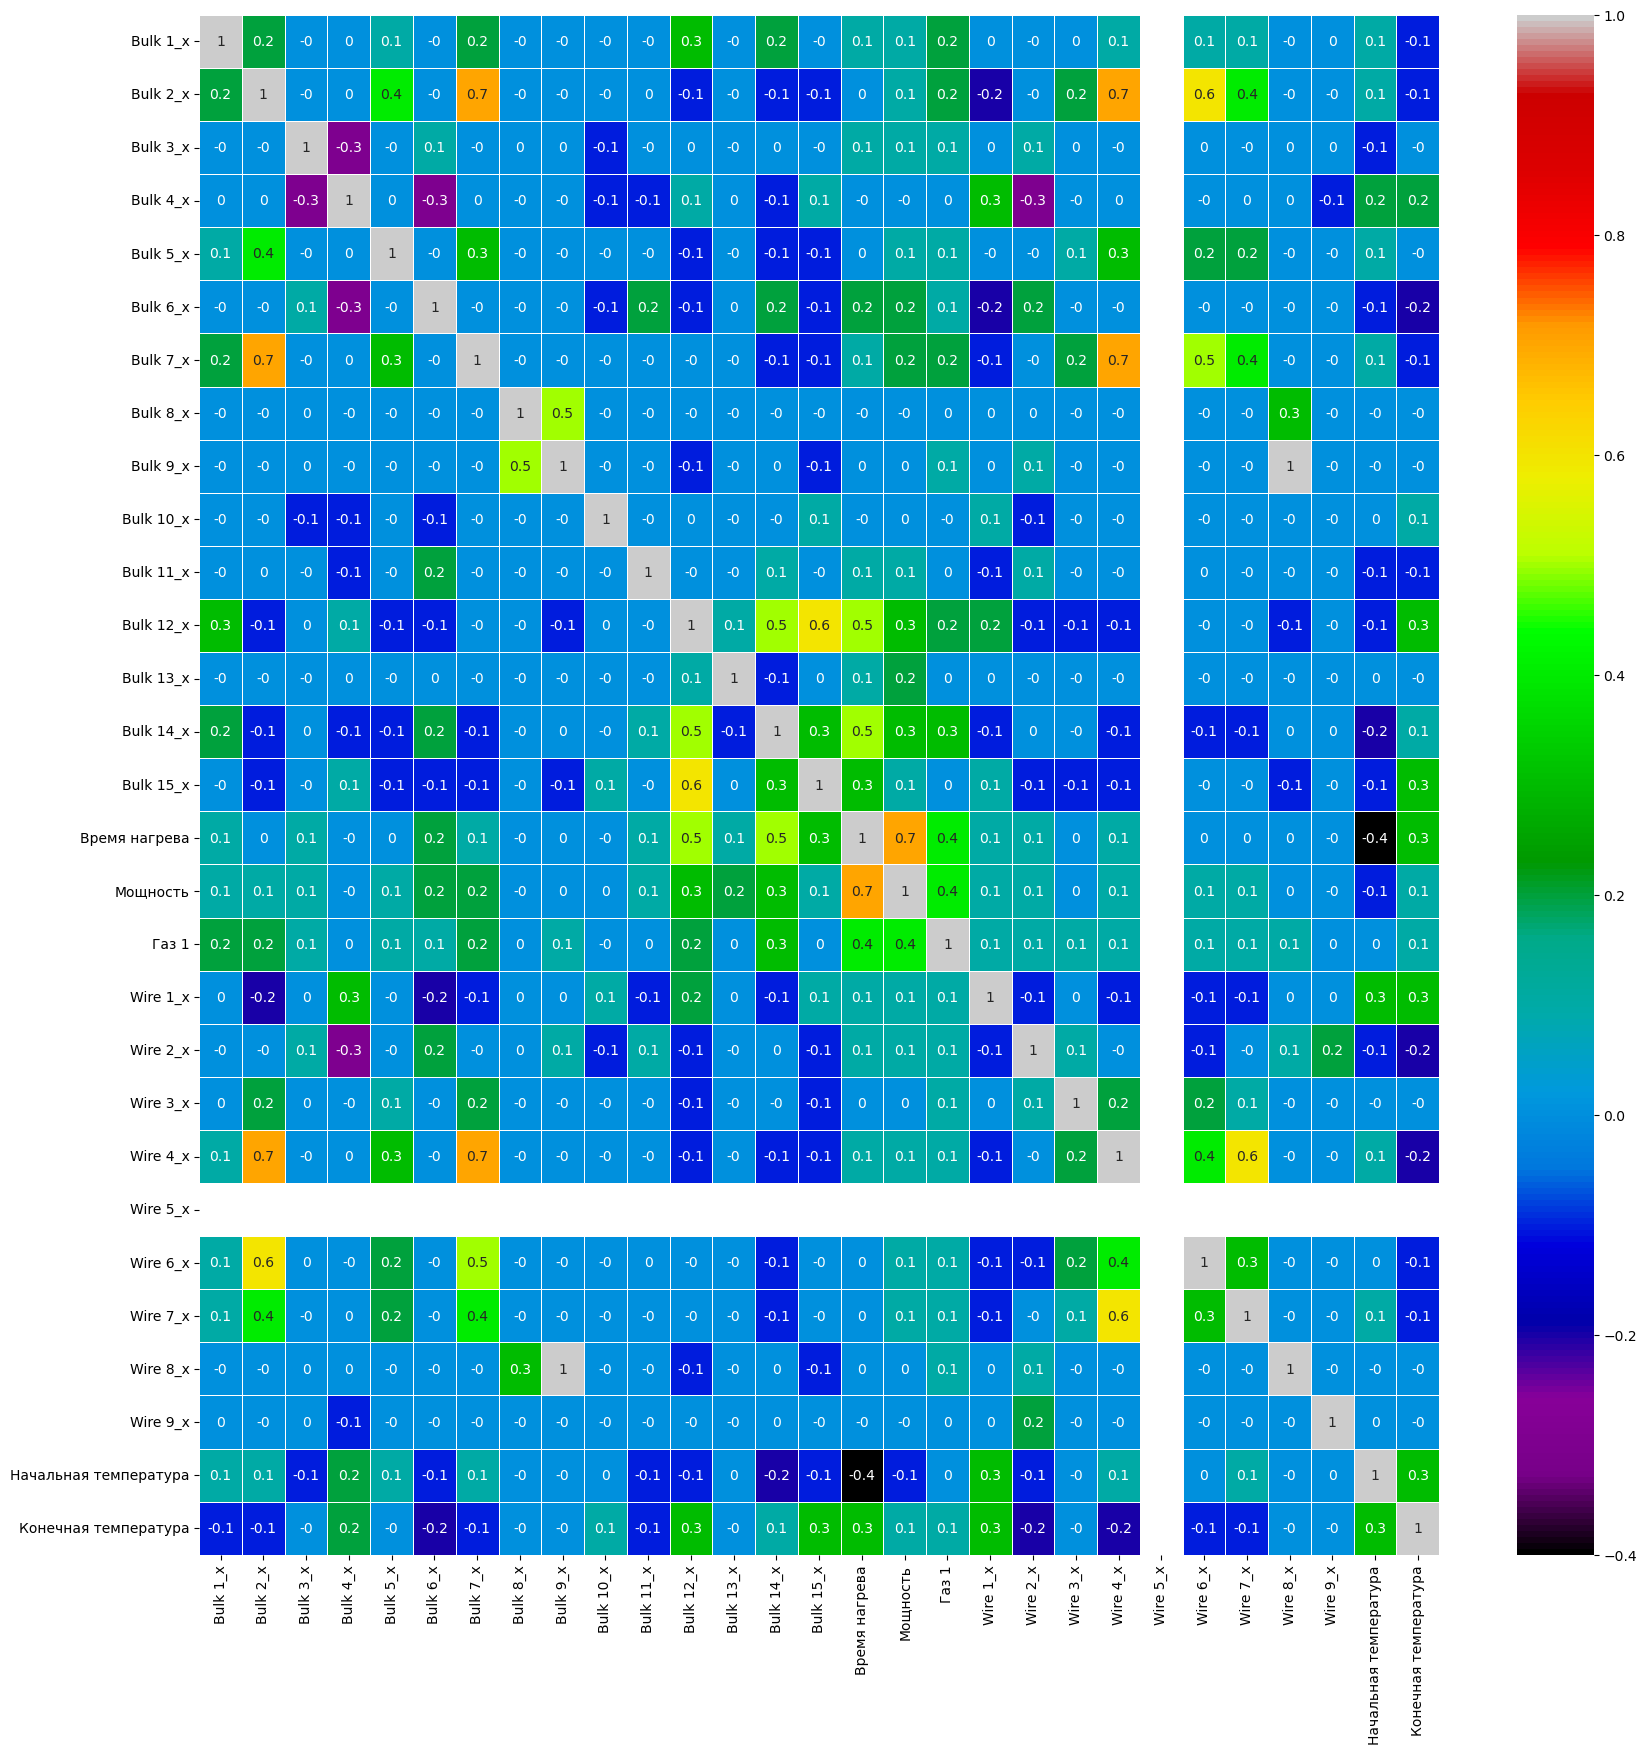

In [40]:
plt.subplots(figsize=(20, 20))
sns.heatmap(dataset.corr().round(1), cmap='nipy_spectral' , annot=True, linewidths=0.5)
plt.show()

Выше 0.7 и меньше -0.4 корреляции нет, кроме 1.0 между Bulk 9_x и Wire 8_x. Однако с другими признаками у них корреляция не совсем похожа. Следовательно, говорить о мультиколлинеарности не приходится.Оставляем оба признака. Удалим Wire 5_x

In [41]:
dataset.drop(['Wire 5_x', 'Wire 8_x'], axis=1, inplace=True)

## Модель

### Деление на выборки

In [42]:
features = dataset.drop('Конечная температура', axis=1)
target = dataset['Конечная температура']

In [43]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=TEST_SIZE, random_state=RANDOM_STATE)

### Pipeline

In [44]:
pipe_dummy = Pipeline([('scaler', StandardScaler()), ('dummy', DummyRegressor())], verbose=True)
pipe_linreg = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())], verbose=True)
pipe_forest = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(random_state=RANDOM_STATE))], verbose=True)
pipe_cat = Pipeline([('scaler', StandardScaler()), ('cat', CatBoostRegressor(random_state=RANDOM_STATE))], verbose=True)

### GridSearchCV

In [45]:
param_dummy = {'dummy__strategy':('mean', 'median')}
param_forest = {'forest__n_estimators': range(50, 151), 'forest__max_depth': range(5, 51)}

In [46]:
grid_dummy = GridSearchCV(pipe_dummy, param_dummy, n_jobs=N_JOBS, cv=CV, verbose=2, scoring='neg_mean_absolute_error')
grid_forest = GridSearchCV(pipe_forest, param_forest, n_jobs=N_JOBS, cv=CV, verbose=2, scoring='neg_mean_absolute_error')

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА 2</b></u></p>
    <p>С пайплайнами - ОК.</p>
</div>

### Обучение

#### DummyRegressor

In [47]:
grid_dummy.fit(features_train, target_train)
mae_dummy = round((grid_dummy.best_score_ * -1), 2)
print(grid_dummy.best_params_)
print(mae_dummy)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing dummy, total=   0.0s
{'dummy__strategy': 'median'}
8.01


#### LinearRegression

In [48]:
mae_linreg = round((cross_val_score(pipe_linreg, features_train, target_train, cv=CV, scoring='neg_mean_absolute_error', n_jobs=N_JOBS).mean() * -1), 2)
print(mae_linreg)

804428998896.43


#### RandomForestRegressor

In [49]:
grid_forest.fit(features_train, target_train)
mae_forest = round((grid_forest.best_score_ * -1), 2)
print(grid_forest.best_params_)
print(mae_forest)

Fitting 3 folds for each of 4646 candidates, totalling 13938 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing forest, total=   0.8s
{'forest__max_depth': 11, 'forest__n_estimators': 90}
6.32


#### CatBoostRegressor

In [58]:
mae_cat = round((cross_val_score(pipe_cat, features_train, target_train, cv=CV, scoring='neg_mean_absolute_error', n_jobs=N_JOBS).mean() * -1), 2)
print(mae_cat)

6.18


## Выбор лучшей модели

In [59]:
models = pd.DataFrame({'model': ['DummyRegressor', 'LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor'], 'MAE': [mae_dummy, mae_linreg, mae_forest, mae_cat]})
models

,model,MAE
0,DummyRegressor,8.010000e+00
1,LinearRegression,8.044290e+11
2,RandomForestRegressor,6.320000e+00
3,CatBoostRegressor,6.180000e+00


Лучше всего оказалась модель `CatBoostRegressor`

## Тестирование лучшей модели

In [52]:
pipe_cat.fit(features_train, target_train)
prediction = pipe_cat.predict(features_test)
mae_test = round((mae(target_test, prediction)), 2)
print(mae_test)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
Learning rate set to 0.0447
0:	learn: 11.1189866	total: 147ms	remaining: 2m 27s
1:	learn: 10.9922830	total: 152ms	remaining: 1m 15s
2:	learn: 10.9000157	total: 155ms	remaining: 51.5s
3:	learn: 10.7829736	total: 158ms	remaining: 39.4s
4:	learn: 10.6720773	total: 161ms	remaining: 32.1s
5:	learn: 10.5800034	total: 164ms	remaining: 27.2s
6:	learn: 10.4915308	total: 167ms	remaining: 23.7s
7:	learn: 10.4076238	total: 170ms	remaining: 21s
8:	learn: 10.3032062	total: 172ms	remaining: 19s
9:	learn: 10.2210367	total: 175ms	remaining: 17.4s
10:	learn: 10.1449915	total: 178ms	remaining: 16s
11:	learn: 10.0758511	total: 181ms	remaining: 14.9s
12:	learn: 10.0093059	total: 183ms	remaining: 13.9s
13:	learn: 9.9354683	total: 186ms	remaining: 13.1s
14:	learn: 9.8579338	total: 188ms	remaining: 12.3s
15:	learn: 9.7830518	total: 190ms	remaining: 11.7s
16:	learn: 9.7226587	total: 193ms	remaining: 11.1s
17:	learn: 9.6469470	total: 195ms	r

Достигнуто хорошее значение метрики MAE (6.2)

## Feature importances

In [53]:
fi = pd.DataFrame({'importance': pipe_cat['cat'].feature_importances_}, index=pipe_cat[:-1].get_feature_names_out())
fi

,importance
Bulk 1_x,2.415110
Bulk 2_x,0.051085
Bulk 3_x,2.783658
Bulk 4_x,2.530631
Bulk 5_x,0.282690
Bulk 6_x,5.360241
Bulk 7_x,2.692993
Bulk 8_x,0.001906
Bulk 9_x,0.047389
Bulk 10_x,0.340549


<AxesSubplot:>

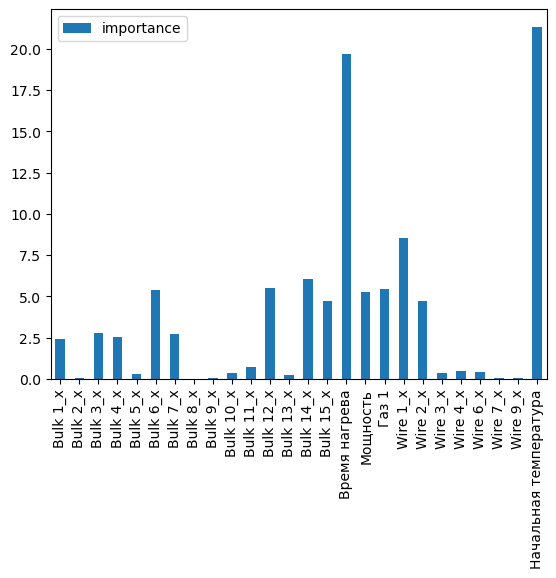

In [54]:
fi.plot.bar()

Наиболее важными признаками для модели были `Начальная температура`, `Время нагрева` и `Wire 1_x`. Незначительные признаки: `Bulk 2_x`, `Bulk 5_x`, `Bulk 8_x`-`Bulk 11_x`, `Bulk 13_x`, `Wire 3_x`-`Wire 9_x`. Посмотрим, как это было связано с пропусками:

In [55]:
is_not_null = (~dataset.isin([0])).sum()
is_not_null

Bulk 1_x                  199
Bulk 2_x                   13
Bulk 3_x                  958
Bulk 4_x                  811
Bulk 5_x                   53
Bulk 6_x                  437
Bulk 7_x                   13
Bulk 8_x                    1
Bulk 9_x                   13
Bulk 10_x                 143
Bulk 11_x                 130
Bulk 12_x                1809
Bulk 13_x                  14
Bulk 14_x                2064
Bulk 15_x                1696
Время нагрева            2324
Мощность                 2324
Газ 1                    2324
Wire 1_x                 2301
Wire 2_x                  809
Wire 3_x                   39
Wire 4_x                   12
Wire 6_x                   45
Wire 7_x                    4
Wire 9_x                   24
Начальная температура    2324
Конечная температура     2324
dtype: int64

In [56]:
for_corr = pd.concat([is_not_null, fi], axis=1)
for_corr.dropna(inplace=True)
for_corr.columns = ['non-null', 'importance']
for_corr

,non-null,importance
Bulk 1_x,199,2.415110
Bulk 2_x,13,0.051085
Bulk 3_x,958,2.783658
Bulk 4_x,811,2.530631
Bulk 5_x,53,0.282690
Bulk 6_x,437,5.360241
Bulk 7_x,13,2.692993
Bulk 8_x,1,0.001906
Bulk 9_x,13,0.047389
Bulk 10_x,143,0.340549


In [57]:
for_corr.corr()

,non-null,importance
non-null,1.000000,0.768986
importance,0.768986,1.000000


Можно сделать вывод, что чем больше пропусков было по признаку, тем он менее важным он стал для модели

## Общий вывод

В изначальных данных есть ошибки:

1. В `data_arc_new['Реактивная мощность']` есть отрицательное значение -715.48 
2. Температура ниже 1300 в `data_temp_new['Температура']`
3. Не везде была измерена температура в конце последнего цикла обработки

Полных дубликатов нет

Есть дубликаты по `key` что связано с разными циклами обработки партии

Данные о некоторых партиях есть не во всех таблицах
Лучше всего проявила себя модель CatBoostRegressor. Удалось достич метрики MAE равной 6.2

Наиболее важными признаками для модели были Начальная температура, Время нагрева и Wire 1_x. Незначительные признаки: Bulk 2_x, Bulk 5_x, Bulk 8_x-Bulk 11_x, Bulk 13_x, Wire 3_x-Wire 9_x. 

Важность признаков имела прямую корреляцию с количеством non-null значений в признаке (корреляция 0.79))

## Отчет

Весь план работы выполнен. Трудностей не возникло.

Ключевые шаги: 

Предобработка данных:
1. Обработка пропусков
2. Обработка выбросов
3. Агрегация таблиц по `key`
4. Объединение таблиц по `key`
5. Создание новых признаков
6. Исследовательский анализ объединенной таблицы (в частности - корреляционный анализ)

Создание модели:
1. Разбиение датасета на `features` и `train`
2. Масштабирование признаков
3. Подбор гиперпараметров и тренировка моделей
4. Выбор лучшей модели и ее тестирование
5. Исследование важности признаков

Список признаков для обучения модели:

Все признаки были масштабированы при помощи StandardScaler

Признаки из `data_bulk_new`:
1. Bulk 1
2. Bulk 2
3. Bulk 3
4. Bulk 4
5. Bulk 5
6. Bulk 6
7. Bulk 7
8. Bulk 8
9. Bulk 9
10. Bulk 10
11. Bulk 11
12. Bulk 12
13. Bulk 13
14. Bulk 14
15. Bulk 15

Признаки из `data_arc_new`:
1. Время нагрева - получено сложением разницы между `Конец нагрева дугой` и `Начало нагрева дугой` для каждого цикла для конкретной партии
2. Мощность - результат перемножения сум  `Активная мощность` и `Реактивная мощность` для каждой партии

Признаки из `data_gas_new`:
1. Газ 1

Признаки из `data_wire_new`:
1. Wire 1
2. Wire 2
3. Wire 3
4. Wire 4
5. Wire 6
6. Wire 7
7. Wire 8
8. Wire 9

Признаки из `data_temp_new`:
1. Начальная температура - самое первое измерение температуры, до начала обработки стали

Гиперпараметры модели:
Лучше всего проявила себя модель CatBoostRegressor. Удалось достич метрики MAE равной 6.2

{'nan_mode': 'Min',

 'eval_metric': 'RMSE',
 
 'iterations': 1000,
 
 'sampling_frequency': 'PerTree',
 
 'leaf_estimation_method': 'Newton',
 
 'grow_policy': 'SymmetricTree',
 
 'penalties_coefficient': 1,
 
 'boosting_type': 'Plain',
 
 'model_shrink_mode': 'Constant',
 
 'feature_border_type': 'GreedyLogSum',
 
 'bayesian_matrix_reg': 0.10000000149011612,
 
 'force_unit_auto_pair_weights': False,
 
 'l2_leaf_reg': 3,
 
 'random_strength': 1,
 
 'rsm': 1,
 
 'boost_from_average': True,
 
 'model_size_reg': 0.5,
 
 'pool_metainfo_options': {'tags': {}},
 
 'subsample': 0.800000011920929,
 
 'use_best_model': False,
 
 'random_seed': 30723,
 
 'depth': 6,
 
 'posterior_sampling': False,
 
 'border_count': 254,
 
 'classes_count': 0,
 
 'auto_class_weights': 'None',
 
 'sparse_features_conflict_fraction': 0,
 
 'leaf_estimation_backtracking': 'AnyImprovement',
 
 'best_model_min_trees': 1,
 
 'model_shrink_rate': 0,
 
 'min_data_in_leaf': 1,
 
 'loss_function': 'RMSE',
 
 'learning_rate': 0.04470000043511391,
 
 'score_function': 'Cosine',
 
 'task_type': 'CPU',
 
 'leaf_estimation_iterations': 1,
 
 'bootstrap_type': 'MVS',
 
 'max_leaves': 64}
 

Для улучшения модели можно попробовать использовать данные каждого цикла обработки